<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Homework 2

</div>


## Import Modules

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Original Code from Lab3

In [29]:
# # Download dataset
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

#### A. Data Loading and Preprocessing

In [42]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800
batch_size = 32

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


#### B. Defining Neural Networks in PyTorch

In [43]:
import torch.nn as nn

# Model in Lab 2
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)


#### C. Training the Neural Network

In [44]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torch.nn.functional as F

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
#         torch.save(model.state_dict(), 'model_classification.pth')
        torch.save(model.state_dict(), 'model_classification_BCEL_L2_W256.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 3.8046, Train Accuracy: 59.12%, Val Loss: 0.4278, Val Accuracy: 85.00%
Epoch 2/30, Train Loss: 0.3748, Train Accuracy: 86.06%, Val Loss: 0.3362, Val Accuracy: 87.50%
Epoch 3/30, Train Loss: 0.2965, Train Accuracy: 88.94%, Val Loss: 0.2777, Val Accuracy: 90.50%
Epoch 4/30, Train Loss: 0.2447, Train Accuracy: 91.25%, Val Loss: 0.2510, Val Accuracy: 90.00%
Epoch 5/30, Train Loss: 0.2158, Train Accuracy: 92.19%, Val Loss: 0.2584, Val Accuracy: 88.50%
Epoch 6/30, Train Loss: 0.1899, Train Accuracy: 93.19%, Val Loss: 0.1998, Val Accuracy: 93.50%
Epoch 7/30, Train Loss: 0.1727, Train Accuracy: 93.50%, Val Loss: 0.2324, Val Accuracy: 91.25%
Epoch 8/30, Train Loss: 0.1898, Train Accuracy: 92.44%, Val Loss: 0.2169, Val Accuracy: 92.50%
Epoch 9/30, Train Loss: 0.1513, Train Accuracy: 94.44%, Val Loss: 0.1830, Val Accuracy: 93.25%
Epoch 10/30, Train Loss: 0.1537, Train Accuracy: 93.94%, Val Loss: 0.1805, Val Accuracy: 93.25%
Epoch 11/30, Train Loss: 0.1607, Train Accuracy: 

#### Visualizing model performance

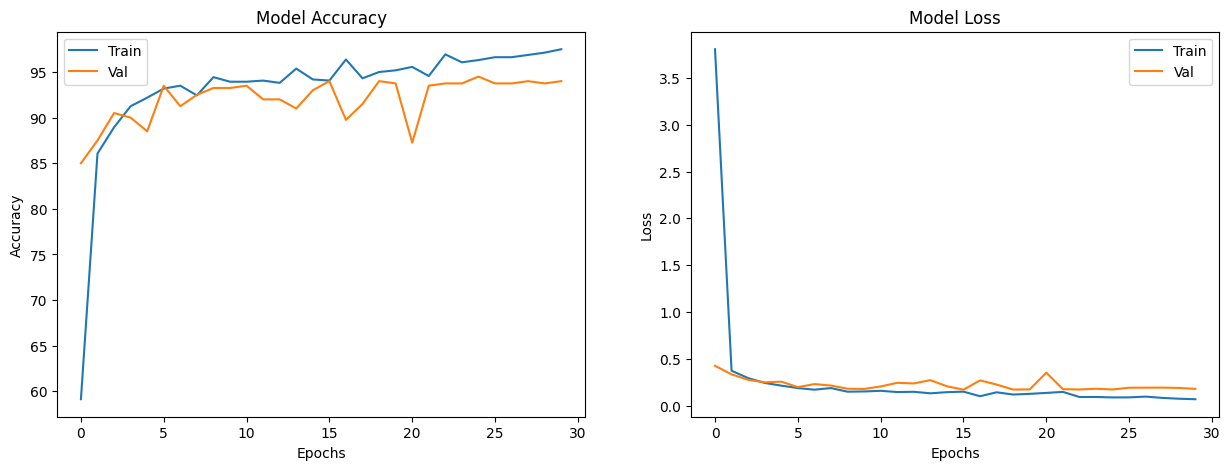

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## Code for 1. Coding 1.1 Task A

### Modification 1
#### Transform labels into one-hot vectors

In [46]:
# Modification 1
# Transfrom labels into one-hot vectors
y_train_one_hot = F.one_hot(y_train.view(-1).to(dtype=torch.long), num_classes=2).to(dtype=torch.float)
y_val_one_hot = F.one_hot(y_val.view(-1).to(dtype=torch.long), num_classes=2).to(dtype=torch.float)

# Create datasets
train_dataset_for_CEL = TensorDataset(x_train, y_train_one_hot)
val_dataset_for_CEL = TensorDataset(x_val, y_val_one_hot)

# Create dataloaders
train_loader_for_CEL = DataLoader(train_dataset_for_CEL, batch_size=batch_size, shuffle=True)
val_loader_for_CEL = DataLoader(val_dataset_for_CEL, batch_size=batch_size, shuffle=False)

### Modification 2
#### Modify the output dimension in the model architecture 

In [47]:
import torch.nn as nn

# Model in Lab 2
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    
    # Modification 2
    # The output dimension should be 2, corresponding to 2 classes in the cross-entropy loss.
    # nn.Linear(256, 1) # original
    nn.Linear(256, 2)  # new
    
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=2, bias=True)
)


### Modification 3
#### modify some details in training algorithm, modification  3.1 ~ 3.8

In [48]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torch.nn.functional as F

train_losses_for_CE = []
val_losses_for_CE = []
train_accuracies_for_CE = []
val_accuracies_for_CE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer

# Modification 3.1
# criterion = nn.BCEWithLogitsLoss()  # original
criterion = nn.CrossEntropyLoss()  # get an instance of the class CrossEntropyLoss.  # new

optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader_for_CEL:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        # Modification 3.2      
        # labels = labels.float().unsqueeze(1)  # remove
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Modification 3.3 
        # modify the prediction formula on training data
        # train_predicted = torch.sigmoid(outputs) > 0.5  # original
        train_predicted = torch.argmax(outputs, dim=1)  # new
        
        # Modification 3.4
        # modify the counting formula on training data
        # train_correct += (train_predicted.float() == labels).sum().item()  # original
        train_correct += (train_predicted == torch.argmax(labels, dim=1)).sum().item()  # new

        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader_for_CEL:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            # Modification 3.5
            # labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)
    
            total_val_loss += loss.item()
            
            # Modification 3.6
            # predicted = torch.sigmoid(outputs) > 0.5  # original
            predicted = torch.argmax(outputs, dim=1)  # new
            
            # Modification 3.7
            # correct += (predicted.float() == labels).sum().item()  # original
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()  # new

            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        # modification 3.8
        # change the file name of checkpoint
        torch.save(model.state_dict(), 'model_classification_CEL_L2_W256.pth')

    # Store performance
    train_losses_for_CE.append(avg_train_loss)
    train_accuracies_for_CE.append(train_accuracy)
    val_losses_for_CE.append(avg_val_loss)
    val_accuracies_for_CE.append(val_accuracy)

Epoch 1/30, Train Loss: 2.8750, Train Accuracy: 71.31%, Val Loss: 0.2736, Val Accuracy: 90.50%
Epoch 2/30, Train Loss: 0.3156, Train Accuracy: 86.75%, Val Loss: 0.2696, Val Accuracy: 88.50%
Epoch 3/30, Train Loss: 0.2707, Train Accuracy: 89.00%, Val Loss: 0.2359, Val Accuracy: 92.25%
Epoch 4/30, Train Loss: 0.1790, Train Accuracy: 93.25%, Val Loss: 0.2185, Val Accuracy: 91.75%
Epoch 5/30, Train Loss: 0.2208, Train Accuracy: 91.06%, Val Loss: 0.1824, Val Accuracy: 94.00%
Epoch 6/30, Train Loss: 0.1837, Train Accuracy: 92.81%, Val Loss: 0.1938, Val Accuracy: 93.25%
Epoch 7/30, Train Loss: 0.1488, Train Accuracy: 94.19%, Val Loss: 0.1951, Val Accuracy: 93.25%
Epoch 8/30, Train Loss: 0.1342, Train Accuracy: 95.06%, Val Loss: 0.1908, Val Accuracy: 93.75%
Epoch 9/30, Train Loss: 0.1247, Train Accuracy: 95.50%, Val Loss: 0.1735, Val Accuracy: 94.00%
Epoch 10/30, Train Loss: 0.1375, Train Accuracy: 94.25%, Val Loss: 0.1695, Val Accuracy: 94.50%
Epoch 11/30, Train Loss: 0.1236, Train Accuracy: 

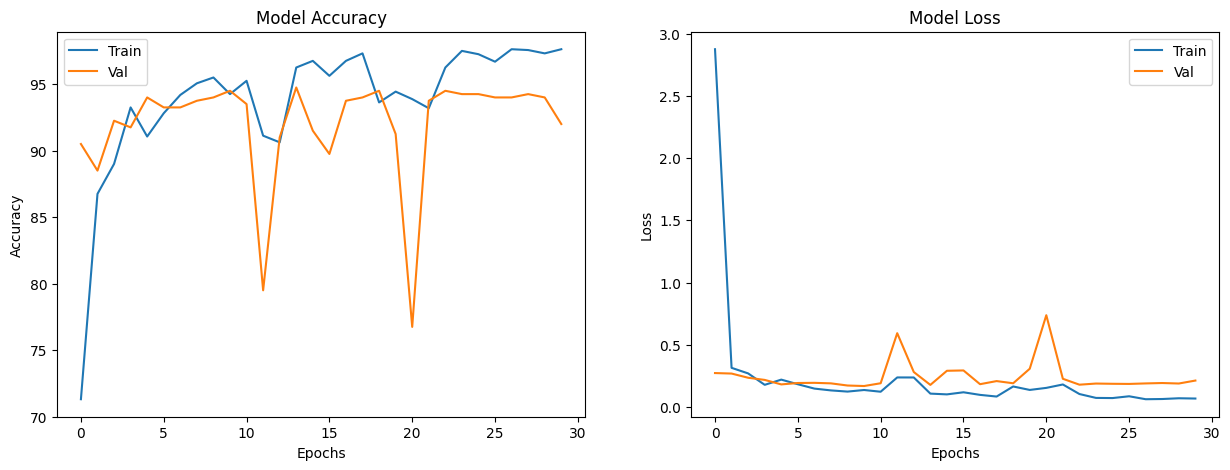

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_for_CE)
ax[0].plot(val_accuracies_for_CE)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_for_CE)
ax[1].plot(val_losses_for_CE)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## Code for 1. Coding   1.2 Task B

### Step 0: Download test dataset

In [9]:
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

### Step 1: Prepare your test dataset

In [51]:
import numpy as np

test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


### Step 2: Load Test Images into PyTorch DataLoader (5 pts)

In [52]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.long)

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Step 3: Prepare Your Trained Model  (5 pts)
- Define the architecture to match exactly with the trained model intended for inference. Ensure strict alignment to avoid errors during evaluation.
- Load the weights from the trained model and set the model to evaluation mode

In [53]:
# Declare the model architecture
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

# Load the trained weights
model.load_state_dict(torch.load('model_classification_BCEL_L2_W256.pth'))

# Set the model to evaluation mode
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)

### Step 4: Perform Inference and Calculate the Accuracy (10 pts)
- Ensure the image values are processed in a manner consistent with the training phase.
- Use the model that was trained with BCE loss to execute inference on the test dataset.
- Note that inference should be performed in GPU.

In [54]:
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        images = images / 255.0
        labels = labels.cuda()
        labels = labels.to(dtype=torch.float).unsqueeze(1)
        outputs = model(images)
        
        predicted = torch.sigmoid(outputs) > 0.5
        test_correct += (predicted.float() == labels).sum().item()
        
        test_total += labels.shape[0]

    test_accuracy = 100. * test_correct / test_total
        

# print(f'Test Loss = {avg_test_loss}')
print(f'Test accuracy is {test_accuracy}')        


Test accuracy is 75.25


## Code for 2. Report  2.1 Task A

#### Model using CE Loss

#### 2.1.1 Testing performance of the model using CE Loss

In [55]:
import numpy as np

test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [56]:
# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.long)

# Modification 1
# Transfrom labels into one-hot vectors
y_test_one_hot = F.one_hot(y_test.view(-1).to(dtype=torch.long), num_classes=2).to(dtype=torch.float)

# Combine the images and labels into a dataset
test_dataset_for_CE = TensorDataset(x_test, y_test_one_hot)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader_for_CE = DataLoader(test_dataset_for_CE, batch_size=batch_size, shuffle=False)

In [57]:
# Declare the model architecture
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
).cuda()

# Load the trained weights
model.load_state_dict(torch.load('model_classification_CEL_L2_W256.pth'))

# Set the model to evaluation mode
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=2, bias=True)
)

In [59]:
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader_for_CE:
        images = images.cuda()
        images = images / 255.0
        labels = labels.cuda()
        
        # Modification 3.5
        # labels = labels.to(dtype=torch.float).unsqueeze(1)
        
        outputs = model(images)
        
        # Modification 3.6
        # predicted = torch.sigmoid(outputs) > 0.5  # original
        predicted = torch.argmax(outputs, dim=1)  # new
            
        # Modification 3.7
        # test_correct += (predicted.float() == labels).sum().item()  # original
        test_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()  # new
        
        test_total += labels.shape[0]

    test_accuracy_for_CE = 100. * test_correct / test_total
        

# print(f'Test Loss = {avg_test_loss}')
print(f'Using CE Loss: Test accuracy is {test_accuracy_for_CE}')        


Using CE Loss: Test accuracy is 72.5


#### 2.1.2 Compare the validation accuracies and losses between the model using BCE loss and the model using CE loss

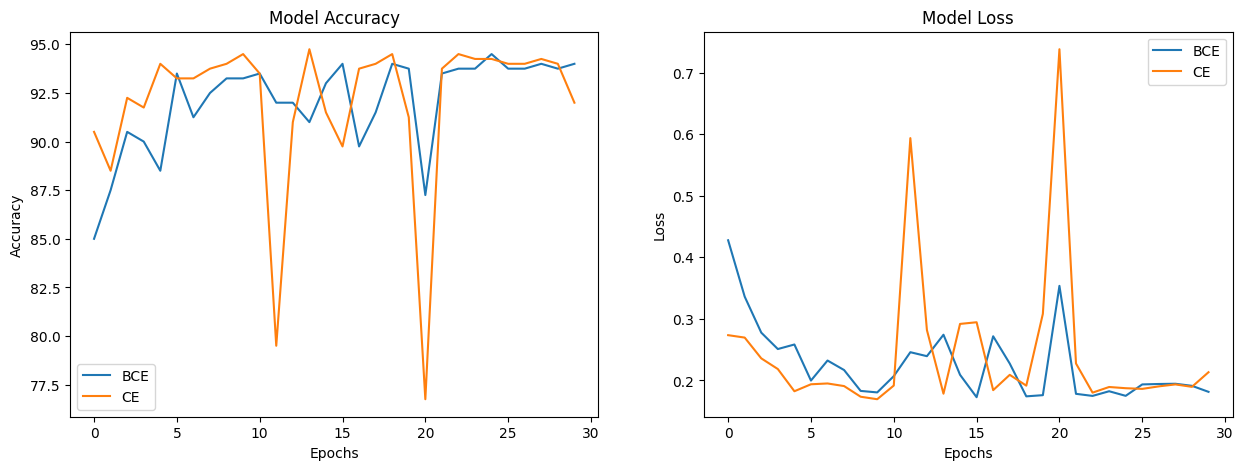

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(val_accuracies)
ax[0].plot(val_accuracies_for_CE)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['BCE', 'CE'])

# Plotting training and validation loss
ax[1].plot(val_losses)
ax[1].plot(val_losses_for_CE)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['BCE', 'CE'])

plt.savefig('./assets/images/comparison_of_validation_ccuracies_and_losses.png')

plt.show()



## Code for 2. Report  2.2 Task B

#### Model 1

    Loss Criterion: BCE Loss

    Layers: 3

    Hidden layer width: 64

    Activation function: ReLU

    Opimizer: Adam

    Learning rate scheduler: StepLR

    epochs: 30

### Data loader functions

In [277]:
# # data_loader for training dataset and validation dataset with 1D labels

# def data_loader():
    
#     # Load Dataset
#     abnormal_scans = np.load('pneumonia.npy')
#     normal_scans = np.load('normal.npy')

#     print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
#     print(f'Shape of normal_scans: {normal_scans.shape}')

#     # For the data having presence of pneumonia assign 1, for the normal ones assign 0.

#     abnormal_labels = np.ones((abnormal_scans.shape[0],))
#     normal_labels = np.zeros((normal_scans.shape[0],))

#     split_point = 800
#     batch_size = 32

#     x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
#     y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
#     x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
#     y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

#     # Convert to PyTorch tensors
#     x_train = torch.from_numpy(x_train).float()
#     y_train = torch.from_numpy(y_train).long()
#     x_val = torch.from_numpy(x_val).float()
#     y_val = torch.from_numpy(y_val).long()

#     # Create datasets
#     train_dataset = TensorDataset(x_train, y_train)
#     val_dataset = TensorDataset(x_val, y_val)

#     # Create dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
#     print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')
    
#     return train_loader, val_loader

In [348]:
# data_loader for training dataset and validation dataset with 1D labels

def data_loader(two_d_output=False, batch_size=32):
    
    # Load Dataset
    abnormal_scans = np.load('pneumonia.npy')
    normal_scans = np.load('normal.npy')

    print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
    print(f'Shape of normal_scans: {normal_scans.shape}')

    # For the data having presence of pneumonia assign 1, for the normal ones assign 0.

    abnormal_labels = np.ones((abnormal_scans.shape[0],))
    normal_labels = np.zeros((normal_scans.shape[0],))

    split_point = 800
#     batch_size = 32

    x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
    y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
    x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
    y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    
    if two_d_output:
        # Modification 1
        # Transfrom labels into one-hot vectors
        y_train = F.one_hot(y_train.view(-1).to(dtype=torch.long), num_classes=2).to(dtype=torch.float)
        y_val = F.one_hot(y_val.view(-1).to(dtype=torch.long), num_classes=2).to(dtype=torch.float)

#     if batch_size == 1:
#         x_train = x_train.unsqueeze(1)
#         x_val = x_val.unsqueeze(1)
    
    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
    print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')
    
    return train_loader, val_loader

In [349]:
# test_data_loader for testing dataset with 1D labels

def test_data_loader(two_d_output=False, batch_size=32):
    test_abnormal = np.load('test_pneumonia.npy')
    test_normal = np.load('test_normal.npy')

    print(f'Shape of test_abnormal: {test_abnormal.shape}')
    print(f'Shape of test_normal: {test_normal.shape}')

    # For the data having presence of pneumonia assign 1, for the normal ones assign 0.
    test_abnormal_labels = np.ones((test_abnormal.shape[0],))
    test_normal_labels = np.zeros((test_normal.shape[0],))

    x_test = np.concatenate((test_abnormal, test_normal), axis=0)
    y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)
    
    # Convert to PyTorch tensors
    x_test = torch.from_numpy(x_test).to(torch.float)
    y_test = torch.from_numpy(y_test).to(torch.long)

    if two_d_output:
        # Modification 1
        # Transfrom labels into one-hot vectors
        y_test = F.one_hot(y_test.view(-1).to(dtype=torch.long), num_classes=2).to(dtype=torch.float)
        
#     if batch_size == 1:
#         x_test = x_test.unsqueeze(1)
        
    # Combine the images and labels into a dataset
    test_dataset = TensorDataset(x_test, y_test)

    # Create a dataloader to load data in batches. Set batch size to 32.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return test_loader

In [175]:
# define Mish activation function

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, x):
        return x * torch.tanh(torch.log(1 + torch.exp(x)))


In [168]:
import torch.nn as nn

# Model in Lab 2
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 256),
#     nn.ReLU(),
#     nn.Linear(256, 1)
# ).cuda()

width = 64

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
#     Mish(),
#     nn.Dropout(0.5), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
#     Mish(),
#     nn.Dropout(0.5), 
    
    nn.Linear(width, 1)
#     nn.Linear(64, 2)
).cuda()


print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)


In [169]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torch.nn.functional as F

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train_loader, val_loader = data_loader()

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
#         images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
#             images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
#         torch.save(model.state_dict(), 'model_classification.pth')
        torch.save(model.state_dict(), 'model_classification_BCEL_L3_W64.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 0.3461, Train Accuracy: 87.19%, Val Loss: 0.2416, Val Accuracy: 93.25%
Epoch 2/30, Train Loss: 0.1864, Train Accuracy: 95.06%, Val Loss: 0.1739, Val Accuracy: 93.25%
Epoch 3/30, Train Loss: 0.1375, Train Accuracy: 95.56%, Val Loss: 0.1497, Val Accuracy: 95.00%
Epoch 4/30, Train Loss: 0.1117, Train Accuracy: 96.19%, Val Loss: 0.1371, Val Accuracy: 93.50%
Epoch 5/30, Train Loss: 0.0892, Train Accuracy: 96.75%, Val Loss: 0.1378, Val Accuracy: 95.25%
Epoch 6/30, Train Loss: 0.0569, Train Accuracy: 98.25%, Val Loss: 0.1206, Val Accuracy: 95.25%
Epoch 7/30, Train Loss: 0.0413, Train Accuracy: 98.56%, Val Loss: 0.1177, Val Accuracy: 95.25%
Epoch 8/30, Train Loss: 0.0411, Train Accuracy: 98.94%, Val Loss: 0.1241, Val Accuracy: 95.25%
Epoch 9/30, Train Loss: 0.0336, Train Accuracy: 98.94%, Val Loss: 0.1275, Val Accuracy: 95.50%
Epoch 10/30, Train Loss: 0.0425, Train Accuracy: 98.75%, Val Loss: 0.1610, Val Accuracy: 92.50%
Epoch 11/30, Train Loss: 0.0251, Train Accuracy: 

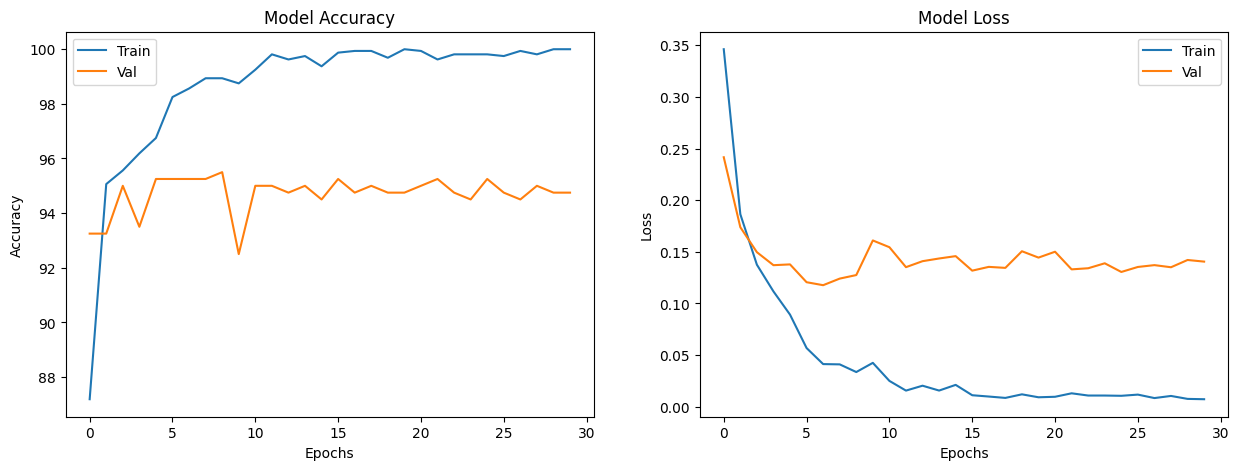

In [170]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [171]:
import numpy as np

test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [172]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.long)

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [173]:
# Declare the model architecture
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 256),
#     nn.ReLU(),
#     nn.Linear(256, 1)
# ).cuda()

# Load the trained weights
# model.load_state_dict(torch.load('model_classification_BCEL_L2_W256.pth'))

# Set the model to evaluation mode
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)

In [174]:
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
#         images = images / 255.0
        labels = labels.cuda()
        labels = labels.to(dtype=torch.float).unsqueeze(1)
        outputs = model(images)
        
        predicted = torch.sigmoid(outputs) > 0.5
        test_correct += (predicted.float() == labels).sum().item()
        
        test_total += labels.shape[0]

    test_accuracy = 100. * test_correct / test_total
        

# print(f'Test Loss = {avg_test_loss}')
print(f'Test accuracy is {test_accuracy}')        


Test accuracy is 78.5


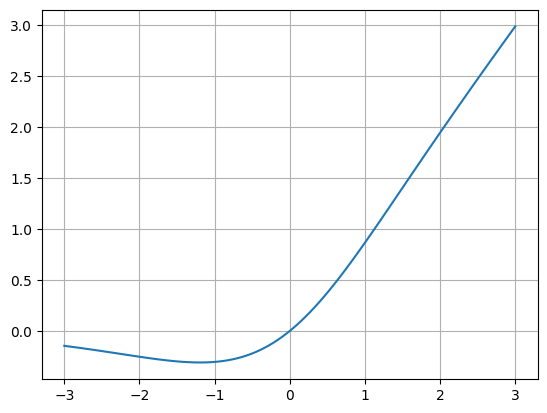

In [181]:
a = torch.linspace(-3, 3, 100)
b = Mish()(a)
plt.plot(a, b)
plt.grid(True)
plt.show()

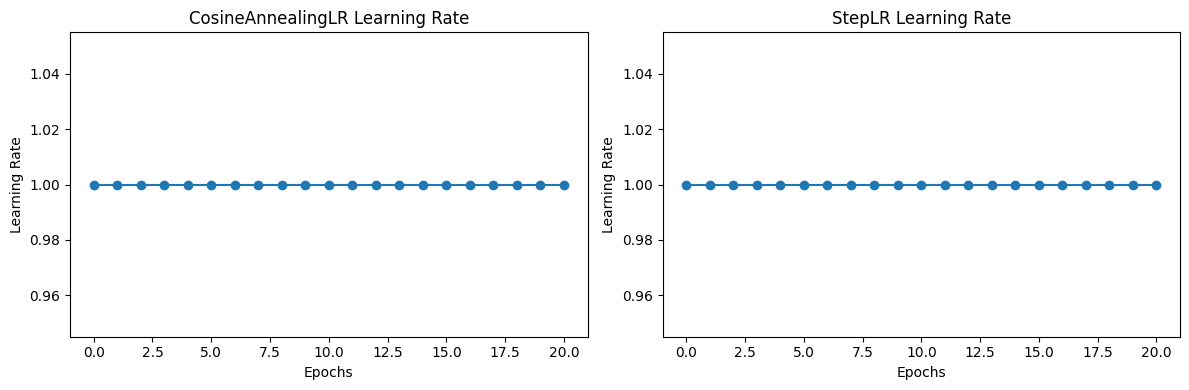

In [183]:
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# Example usage of CosineAnnealingLR
optimizer_cosine = torch.optim.SGD([torch.Tensor([1])], lr=0.1)
scheduler_cosine = CosineAnnealingLR(optimizer_cosine, T_max=20, eta_min=0)

# Example usage of StepLR
optimizer_step = torch.optim.SGD([torch.Tensor([1])], lr=0.1)
scheduler_step = StepLR(optimizer_step, step_size=5, gamma=0.5)

# Lists to store learning rates
lr_cosine = []
lr_step = []

# Iterate through epochs and record learning rates
for epoch in range(21):
    lr_cosine.append(optimizer_cosine.param_groups[0]['lr'])
    lr_step.append(optimizer_step.param_groups[0]['lr'])
    optimizer_cosine.step()
    optimizer_step.step()

# Create x values for plotting
epochs = list(range(21))

# Plot the learning rate curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, lr_cosine, marker='o')
plt.title('CosineAnnealingLR Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.subplot(1, 2, 2)
plt.plot(epochs, lr_step, marker='o')
plt.title('StepLR Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()



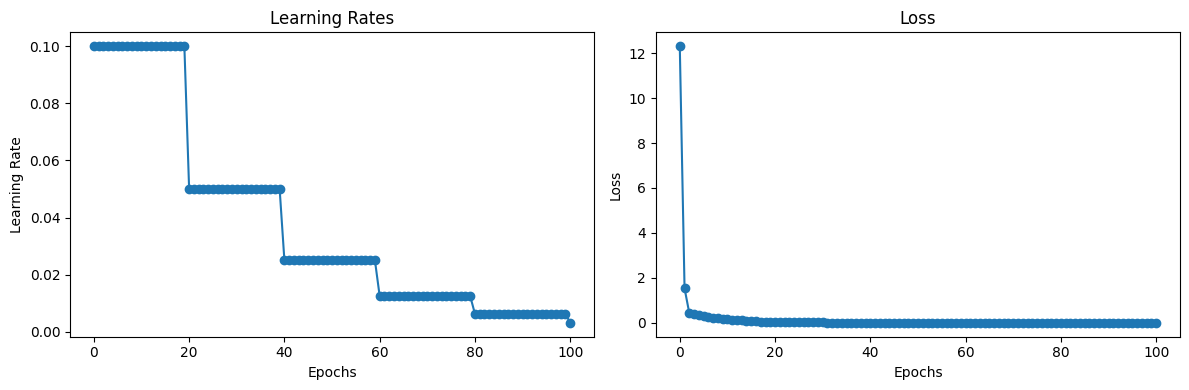

In [208]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Generate synthetic data
data = torch.FloatTensor(np.random.rand(100, 1))
target = 3 * data + 2

# Create a model, loss function, and optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning rate scheduler (e.g., StepLR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Lists to store learning rates and losses
learning_rates = []
losses = []

# Training loop
for epoch in range(101):
    optimizer.zero_grad()
    
    learning_rates.append(optimizer.param_groups[0]['lr'])

    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()  # Perform one gradient descent step
    scheduler.step()   # Adjust learning rate according to the scheduler
    losses.append(loss.item())

# Plot learning rates and losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(learning_rates, marker='o')
plt.title('Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.subplot(1, 2, 2)
plt.plot(losses, marker='o')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


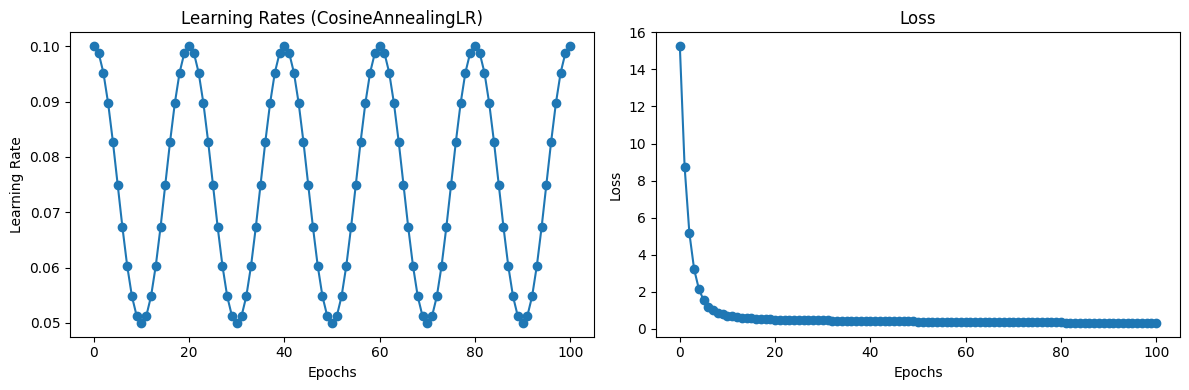

In [215]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        return self.fc(x)

# Generate synthetic data
data = torch.FloatTensor(np.random.rand(100, 1))
target = 3 * data + 2 + 0.5 * torch.randn(100, 1)

# Create a model, loss function, and optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning rate scheduler (CosineAnnealingLR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.05)

# Lists to store learning rates and losses
learning_rates = []
losses = []

# Training loop
for epoch in range(101):
    optimizer.zero_grad()
    learning_rates.append(optimizer.param_groups[0]['lr'])

    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()  # Perform one gradient descent step
    scheduler.step()   # Adjust learning rate according to the scheduler

    losses.append(loss.item())

# Plot learning rates and losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(learning_rates, marker='o')
plt.title('Learning Rates (CosineAnnealingLR)')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.subplot(1, 2, 2)
plt.plot(losses, marker='o')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


### early stop

In [223]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        return self.fc(x)

# Generate synthetic data
X = torch.randn(100, 1)
y = 3 * X + 2 + 0.1 * torch.randn(100, 1)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a model, loss function, and optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Early stopping parameters
patience = 3
epsilon = 10 ** -5
best_val_loss = float('inf')
counter = 0

# Training loop with early stopping
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    print(f"Epoch [{epoch + 1}/1000], Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    if torch.abs(val_loss - best_val_loss) < epsilon:
        counter += 1
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss

    if counter >= patience:
        print("Early stopping after no improvement.")
        break


Epoch [1/1000], Loss: 13.003582954406738, Val Loss: 11.477367401123047
Epoch [2/1000], Loss: 12.499675750732422, Val Loss: 11.029094696044922
Epoch [3/1000], Loss: 12.01531982421875, Val Loss: 10.598321914672852
Epoch [4/1000], Loss: 11.54975700378418, Val Loss: 10.184367179870605
Epoch [5/1000], Loss: 11.102256774902344, Val Loss: 9.786578178405762
Epoch [6/1000], Loss: 10.672119140625, Val Loss: 9.404317855834961
Epoch [7/1000], Loss: 10.258667945861816, Val Loss: 9.036981582641602
Epoch [8/1000], Loss: 9.86125659942627, Val Loss: 8.683988571166992
Epoch [9/1000], Loss: 9.479262351989746, Val Loss: 8.344779968261719
Epoch [10/1000], Loss: 9.112088203430176, Val Loss: 8.018815040588379
Epoch [11/1000], Loss: 8.759157180786133, Val Loss: 7.705577850341797
Epoch [12/1000], Loss: 8.419916152954102, Val Loss: 7.404571533203125
Epoch [13/1000], Loss: 8.093835830688477, Val Loss: 7.115318298339844
Epoch [14/1000], Loss: 7.780403137207031, Val Loss: 6.837359428405762
Epoch [15/1000], Loss: 7

### Try different architectures and hyperparameters

#### model 1
    width = 64
    layers = 3
    activation = 'ReLU'
    dropout = 0.0
    
    normalizing input
    initial learning rate
    lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    with early stop

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Epoch 1/50, Train Loss: 0.3070, Train Accu.: 86.56% Val Loss: 0.1928, Val Accu.: 93.75% Test Loss: 0.4930, Test Accu.: 76.25%


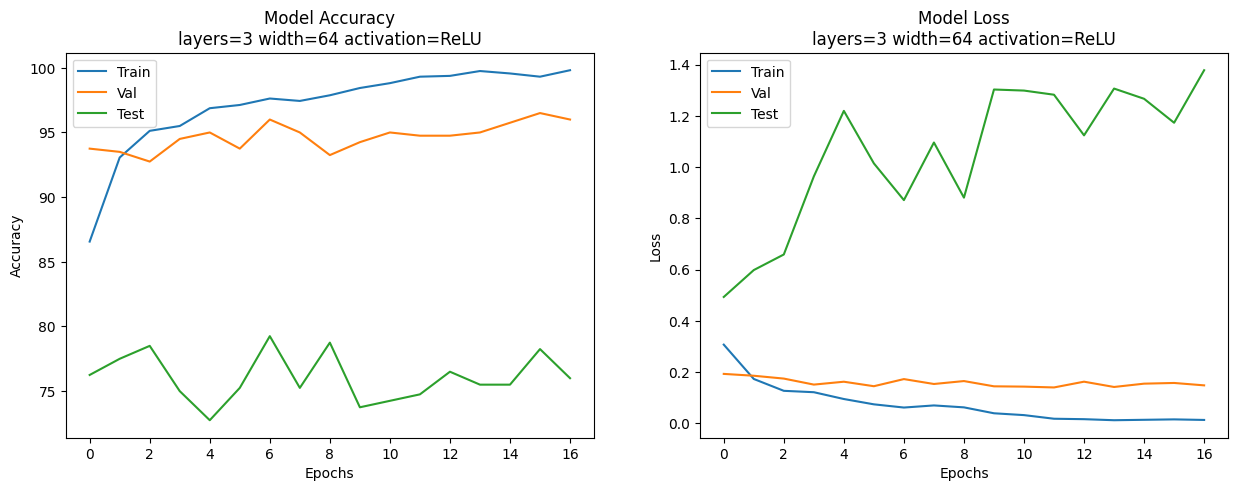

In [268]:
width = 64
layers = 3
activation = 'ReLU' # Mish
dropout = 0.0

checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
#     Mish(),
#     nn.Dropout(0.5), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
#     Mish(),
#     nn.Dropout(0.5), 
    
    nn.Linear(width, 1)
#     nn.Linear(64, 2)
).cuda()


print(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies=[]

train_loader, val_loader = data_loader()
test_loader = test_data_loader()

epochs = 50
best_val_loss = float('inf')

# hyperparameters for early stop
patience = 2
epsilon = 0.01
counter = 0

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
#         images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Evaluation
    model.eval()
    
    with torch.no_grad():
        # validation
        total_val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in val_loader:
            images = images.cuda()
#             images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted.float() == labels).sum().item()
            val_total += labels.size(0)
        
        # testing
        total_test_loss = 0.0
        test_correct = 0
        test_total = 0
            
        for images, labels in test_loader:
            images = images.cuda()
#             images = images / 255.0
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_test_loss += loss.item()
            
            predicted = torch.sigmoid(outputs) > 0.5 
            test_correct += (predicted.float() == labels).sum().item()
            test_total += labels.shape[0]

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
                                      f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
                                      f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
          
    # early stop
    if np.abs(avg_val_loss - best_val_loss) < epsilon:
        counter += 1

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_filename)
        counter = 0

    if counter >= patience:
        print("Early stopping after no improvement.")
        break
        


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].plot(test_accuracies)
ax[0].set_title(f'Model Accuracy\nlayers={layers} width={width} activation={activation}')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val', 'Test'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].plot(test_losses)
ax[1].set_title(f'Model Loss\nlayers={layers} width={width} activation={activation}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val', 'Test'])

plt.savefig(f'./assets/images/alter_hyperparameters_L{layers}_W{width}_{activation}.png')

plt.show()

#### model 2
    width = 128
    layers = 3
    activation = 'Mish'
    dropout = 0.5
    
    normalizing input
    initial learning rate = 0.01
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
    with early stop

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=128, bias=True)
  (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Mish()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Mish()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=128, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Epoch 1/50, Train Loss: 0.3490, Train Accu.: 

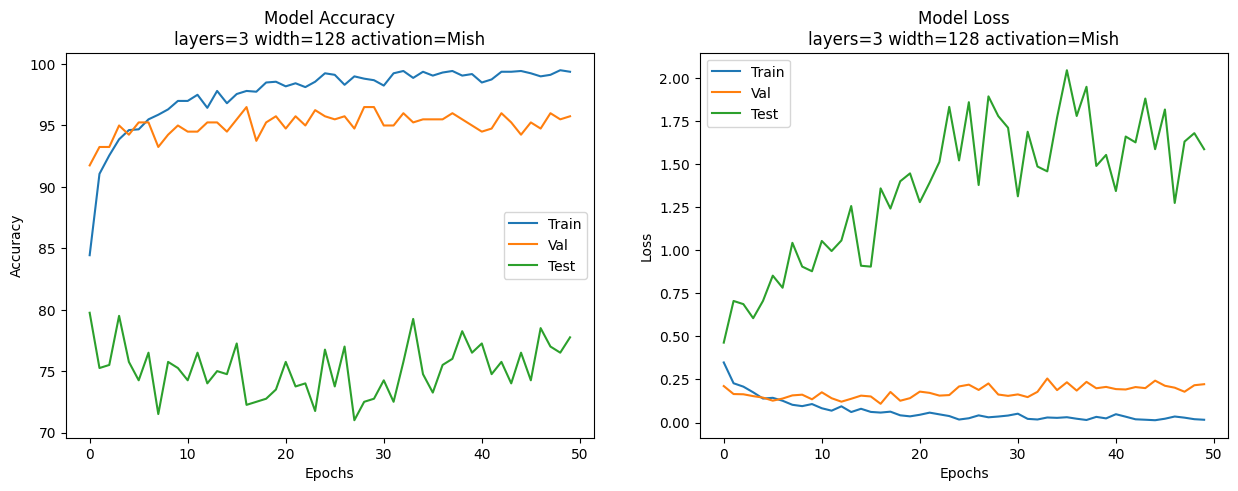

In [271]:
width = 128
layers = 3
activation = 'Mish'
dropout = 0.5

checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
#     nn.ReLU(), 
    Mish(),
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
#     nn.ReLU(), 
    Mish(),
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()


print(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies=[]

train_loader, val_loader = data_loader()
test_loader = test_data_loader()

epochs = 50
best_val_loss = float('inf')

# hyperparameters for early stop
patience = 2
epsilon = 0.01
counter = 0

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
#         images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Evaluation
    model.eval()
    
    with torch.no_grad():
        # validation
        total_val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in val_loader:
            images = images.cuda()
#             images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted.float() == labels).sum().item()
            val_total += labels.size(0)
        
        # testing
        total_test_loss = 0.0
        test_correct = 0
        test_total = 0
            
        for images, labels in test_loader:
            images = images.cuda()
#             images = images / 255.0
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_test_loss += loss.item()
            
            predicted = torch.sigmoid(outputs) > 0.5 
            test_correct += (predicted.float() == labels).sum().item()
            test_total += labels.shape[0]

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
                                      f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
                                      f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
          
    # early stop
    if np.abs(avg_val_loss - best_val_loss) < epsilon:
        counter += 1

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_filename)
        counter = 0

    if counter >= patience:
        print("Early stopping after no improvement.")
        break
        


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].plot(test_accuracies)
ax[0].set_title(f'Model Accuracy\nlayers={layers} width={width} activation={activation}')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val', 'Test'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].plot(test_losses)
ax[1].set_title(f'Model Loss\nlayers={layers} width={width} activation={activation}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val', 'Test'])

plt.savefig(f'./assets/images/alter_hyperparameters_L{layers}_W{width}_{activation}.png')

plt.show()

#### model 3
    width = 256
    layers = 2
    activation = 'ReLU'
    dropout = 0.0
    
    normalizing input
    initial learning rate = 0.01
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
    with early stop

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=256, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Epoch 1/50, Train Loss: 0.2695, Train Accu.: 89.06% Val Loss: 0.2369, Val Accu.: 90.25% Test Loss: 0.7551, Test Accu.: 71.00%
Epoch 2/50, Train Loss: 0.1981, Train Accu.: 92.00% Val Loss: 0.1736, Val Accu.: 93.75% Test Loss: 0.7288, Test Accu.: 

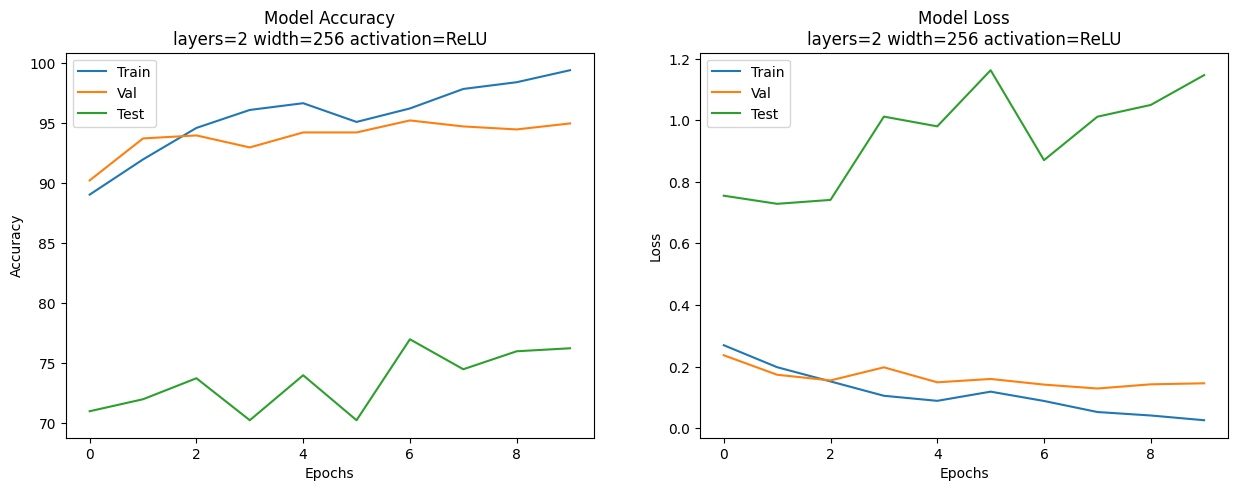

In [270]:
width = 256
layers = 2
activation = 'ReLU'
dropout = 0.0

checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
#     Mish(),
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()


print(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies=[]

train_loader, val_loader = data_loader()
test_loader = test_data_loader()

epochs = 50
best_val_loss = float('inf')

# hyperparameters for early stop
patience = 2
epsilon = 0.02
counter = 0

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
#         images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Evaluation
    model.eval()
    
    with torch.no_grad():
        # validation
        total_val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in val_loader:
            images = images.cuda()
#             images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted.float() == labels).sum().item()
            val_total += labels.size(0)
        
        # testing
        total_test_loss = 0.0
        test_correct = 0
        test_total = 0
            
        for images, labels in test_loader:
            images = images.cuda()
#             images = images / 255.0
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_test_loss += loss.item()
            
            predicted = torch.sigmoid(outputs) > 0.5 
            test_correct += (predicted.float() == labels).sum().item()
            test_total += labels.shape[0]

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
                                      f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
                                      f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
          
    # early stop
    if np.abs(avg_val_loss - best_val_loss) < epsilon:
        counter += 1

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_filename)
        counter = 0

    if counter >= patience:
        print("Early stopping after no improvement.")
        break
        


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].plot(test_accuracies)
ax[0].set_title(f'Model Accuracy\nlayers={layers} width={width} activation={activation}')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val', 'Test'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].plot(test_losses)
ax[1].set_title(f'Model Loss\nlayers={layers} width={width} activation={activation}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val', 'Test'])

plt.savefig(f'./assets/images/alter_hyperparameters_L{layers}_W{width}_{activation}.png')

plt.show()

#### model 4
    width = 64
    layers = 5
    activation = 'ReLU'
    dropout = 0.0
    
    normalizing input
    initial learning rate = 0.01
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
    with early stop

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Dropout(p=0.0, inplace=False)
  (10): Linear(in_features=64, out_features=64, bias=True)
  (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.0, inplace=False)
  (14): Linear(in_features=64, out_features=64, bias=True)
  (15): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU()
  (17): Dropout(p=0.0, inplace=False)
  (18): Linear(in_features=64, out_features=1, bias=True)
)
Sha

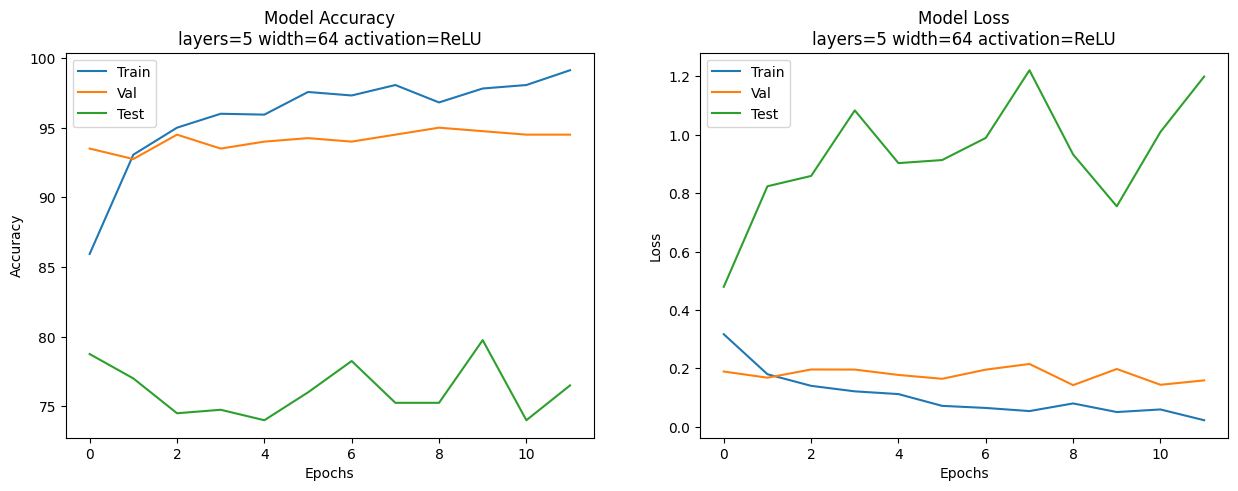

In [273]:
width = 64
layers = 5
activation = 'ReLU'
dropout = 0.0

checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()


print(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies=[]

train_loader, val_loader = data_loader()
test_loader = test_data_loader()

epochs = 50
best_val_loss = float('inf')

# hyperparameters for early stop
patience = 2
epsilon = 0.02
counter = 0

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
#         images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Evaluation
    model.eval()
    
    with torch.no_grad():
        # validation
        total_val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in val_loader:
            images = images.cuda()
#             images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted.float() == labels).sum().item()
            val_total += labels.size(0)
        
        # testing
        total_test_loss = 0.0
        test_correct = 0
        test_total = 0
            
        for images, labels in test_loader:
            images = images.cuda()
#             images = images / 255.0
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_test_loss += loss.item()
            
            predicted = torch.sigmoid(outputs) > 0.5 
            test_correct += (predicted.float() == labels).sum().item()
            test_total += labels.shape[0]

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
                                      f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
                                      f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
          
    # early stop
    if np.abs(avg_val_loss - best_val_loss) < epsilon:
        counter += 1

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_filename)
        counter = 0

    if counter >= patience:
        print("Early stopping after no improvement.")
        break
        


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].plot(test_accuracies)
ax[0].set_title(f'Model Accuracy\nlayers={layers} width={width} activation={activation}')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val', 'Test'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].plot(test_losses)
ax[1].set_title(f'Model Loss\nlayers={layers} width={width} activation={activation}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val', 'Test'])

plt.savefig(f'./assets/images/alter_hyperparameters_L{layers}_W{width}_{activation}.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Dropout(p=0.0, inplace=False)
  (10): Linear(in_features=64, out_features=64, bias=True)
  (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.0, inplace=False)
  (14): Linear(in_features=64, out_features=64, bias=True)
  (15): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU()
  (17): Dropout(p=0.0, inplace=False)
  (18): Linear(in_features=64, out_features=1, bias=True)
)
Sha

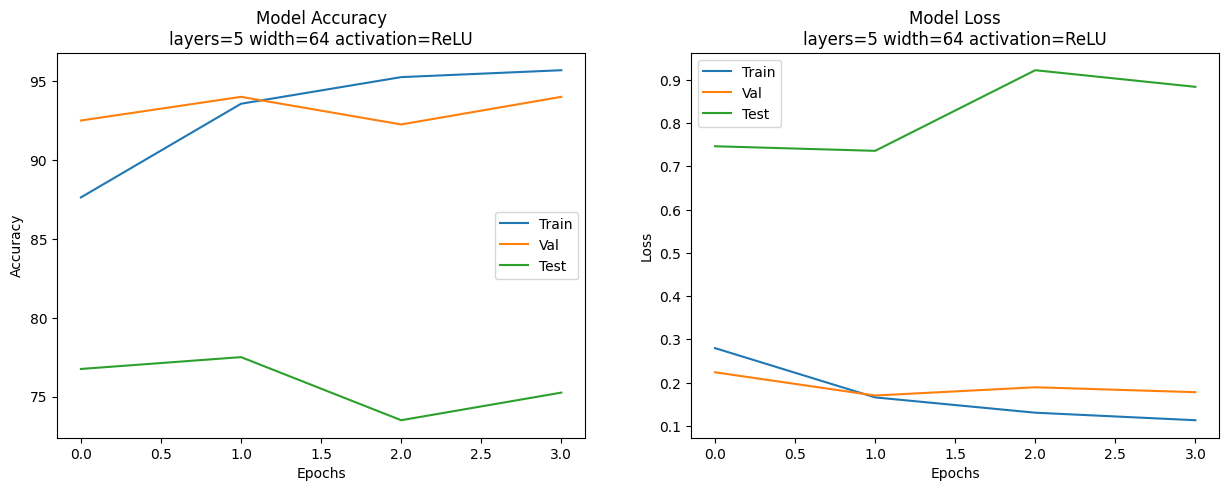

In [298]:
width = 64
layers = 5
activation = 'ReLU'
dropout = 0.0

checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()


print(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies=[]

train_loader, val_loader = data_loader()
test_loader = test_data_loader()

epochs = 50
best_val_loss = float('inf')

# hyperparameters for early stop
patience = 2
epsilon = 0.02
counter = 0

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*3, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
#         images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        
        labels = labels.float().unsqueeze(1)
        
        loss = criterion(outputs, labels)  # for BCEWithLogitsloss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Evaluation
    model.eval()
    
    with torch.no_grad():
        # validation
        total_val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in val_loader:
            images = images.cuda()
#             images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            
            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted.float() == labels).sum().item()
            val_total += labels.size(0)
        
        # testing
        total_test_loss = 0.0
        test_correct = 0
        test_total = 0
            
        for images, labels in test_loader:
            images = images.cuda()
#             images = images / 255.0
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)  
            
            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            total_test_loss += loss.item()
            
            predicted = torch.sigmoid(outputs) > 0.5 
            test_correct += (predicted.float() == labels).sum().item()
            test_total += labels.shape[0]

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
                                      f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
                                      f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
          
    # early stop
    if np.abs(avg_val_loss - best_val_loss) < epsilon:
        counter += 1

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_filename)
        counter = 0

    if counter >= patience:
        print("Early stopping after no improvement.")
        break
        


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].plot(test_accuracies)
ax[0].set_title(f'Model Accuracy\nlayers={layers} width={width} activation={activation}')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val', 'Test'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].plot(test_losses)
ax[1].set_title(f'Model Loss\nlayers={layers} width={width} activation={activation}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val', 'Test'])

plt.savefig(f'./assets/images/alter_hyperparameters_L{layers}_W{width}_{activation}.png')

plt.show()

### Comparison of BCE and CE

In [303]:
# def training(model, train_loader, val_loader, test_loader, epochs, patience, epsilon, criterion, optimizer, lr_scheduler):
#     best_val_loss = float('inf')
#     counter = 0
#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []
#     test_losses = []
#     test_accuracies=[]

#     optimizer = optim.Adam(model.parameters(), lr=1e-2)
#     # lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
#     lr_scheduler = CosineAnnealingLR(optimizer, T_max=3, eta_min=0)
#     # lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
#     for epoch in range(epochs):
#         # Training
#         model.train()
#         total_loss = 0.0
#         train_correct = 0
#         total_train_samples = 0

#         for images, labels in train_loader:
#             images = images.cuda()
#             # images = images / 255.
#             labels = labels.cuda()
#             optimizer.zero_grad()
#             outputs = model(images)

#             labels = labels.float().unsqueeze(1)

#             loss = criterion(outputs, labels)  # for BCEWithLogitsloss
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#             train_predicted = torch.sigmoid(outputs) > 0.5
#             train_correct += (train_predicted.float() == labels).sum().item()
#             total_train_samples += labels.size(0)

#         avg_train_loss = total_loss / len(train_loader)
#         train_accuracy = 100. * train_correct / total_train_samples

#         # Evaluation
#         model.eval()

#         with torch.no_grad():
#             # validation
#             total_val_loss = 0.0
#             val_correct = 0
#             val_total = 0

#             for images, labels in val_loader:
#                 images = images.cuda()
#                 # images = images / 255.
#                 labels = labels.cuda()
#                 outputs = model(images)

#                 labels = labels.float().unsqueeze(1)  

#                 loss = criterion(outputs, labels)  # for BCEWithLogitsloss
#                 total_val_loss += loss.item()

#                 predicted = torch.sigmoid(outputs) > 0.5
#                 val_correct += (predicted.float() == labels).sum().item()
#                 val_total += labels.size(0)

#             # testing
#             total_test_loss = 0.0
#             test_correct = 0
#             test_total = 0

#             for images, labels in test_loader:
#                 images = images.cuda()
#                 # images = images / 255.0
#                 labels = labels.cuda()
#                 outputs = model(images)

#                 labels = labels.float().unsqueeze(1)  

#                 loss = criterion(outputs, labels)  # for BCEWithLogitsloss
#                 total_test_loss += loss.item()

#                 predicted = torch.sigmoid(outputs) > 0.5 
#                 test_correct += (predicted.float() == labels).sum().item()
#                 test_total += labels.shape[0]

#         avg_val_loss = total_val_loss / len(val_loader)
#         val_accuracy = 100. * val_correct / val_total
#         avg_test_loss = total_test_loss / len(test_loader)
#         test_accuracy = 100. * test_correct / test_total
#         print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
#                                           f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
#                                           f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

#         # Learning rate update
#         lr_scheduler.step()

#         # Store performance
#         train_losses.append(avg_train_loss)
#         train_accuracies.append(train_accuracy)
#         val_losses.append(avg_val_loss)
#         val_accuracies.append(val_accuracy)
#         test_losses.append(avg_test_loss)
#         test_accuracies.append(test_accuracy)

#         # early stop
#         if np.abs(avg_val_loss - best_val_loss) < epsilon:
#             counter += 1

#         # Checkpoint
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             torch.save(model.state_dict(), checkpoint_filename)
#             counter = 0

#         if counter >= patience:
#             print("Early stopping after no improvement.")
#             break

#     return model, train_losses, train_accuracies, \
#                   val_losses, val_accuracies, \
#                   test_losses, test_accuracies 

In [307]:
def BCE_predict(outputs, labels):
    predicted = torch.sigmoid(outputs) > 0.5
    return (predicted.float() == labels).sum().item()

def CE_predict(outputs, labels):
    predicted = torch.argmax(outputs, dim=1)
    return (predicted == torch.argmax(labels, dim=1)).sum().item()


def training(model, train_loader, val_loader, test_loader, epochs, patience, epsilon, criterion, optimizer, lr_scheduler, loss_mode='BCE'):
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    test_losses = []
    test_accuracies=[]

    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    # lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=3, eta_min=0)
    # lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0.0
        train_correct = 0
        total_train_samples = 0

        for images, labels in train_loader:
            images = images.cuda()
            # images = images / 255.
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            
            if loss_mode == 'BCE':
                labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)  # for BCEWithLogitsloss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

#             train_predicted = torch.sigmoid(outputs) > 0.5
#             train_correct += (train_predicted.float() == labels).sum().item()
            if loss_mode == 'BCE':
                train_correct += BCE_predict(outputs, labels)
            elif loss_mode == 'CE':
                train_correct += CE_predict(outputs, labels)
            else:
                raise ValueError("This is a custom error message")
                
            total_train_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100. * train_correct / total_train_samples

        # Evaluation
        model.eval()

        with torch.no_grad():
            # validation
            total_val_loss = 0.0
            val_correct = 0
            val_total = 0

            for images, labels in val_loader:
                images = images.cuda()
                # images = images / 255.
                labels = labels.cuda()
                outputs = model(images)
                if loss_mode == 'BCE':
                    labels = labels.float().unsqueeze(1)  

                loss = criterion(outputs, labels)  # for BCEWithLogitsloss
                total_val_loss += loss.item()

                if loss_mode == 'BCE':
                    val_correct += BCE_predict(outputs, labels)
                elif loss_mode == 'CE':
                    val_correct += CE_predict(outputs, labels)
                else:
                    raise ValueError("This is a custom error message")

                val_total += labels.size(0)

            # testing
            total_test_loss = 0.0
            test_correct = 0
            test_total = 0

            for images, labels in test_loader:
                images = images.cuda()
                # images = images / 255.0
                labels = labels.cuda()
                outputs = model(images)
                
                if loss_mode == 'BCE':
                    labels = labels.float().unsqueeze(1)  

                loss = criterion(outputs, labels)  # for BCEWithLogitsloss
                total_test_loss += loss.item()

                if loss_mode == 'BCE':
                    test_correct += BCE_predict(outputs, labels)
                elif loss_mode == 'CE':
                    test_correct += CE_predict(outputs, labels)
                else:
                    raise ValueError("This is a custom error message")
                    
                test_total += labels.shape[0]

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100. * test_correct / test_total
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accu.: {train_accuracy:.2f}%',
                                          f'Val Loss: {avg_val_loss:.4f}, Val Accu.: {val_accuracy:.2f}%',
                                          f'Test Loss: {avg_test_loss:.4f}, Test Accu.: {test_accuracy:.2f}%')

        # Learning rate update
        lr_scheduler.step()

        # Store performance
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        # early stop
        if np.abs(avg_val_loss - best_val_loss) < epsilon:
            counter += 1

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_filename)
            counter = 0

        if counter >= patience:
            print("Early stopping after no improvement.")
            break

    return model, train_losses, train_accuracies, \
                  val_losses, val_accuracies, \
                  test_losses, test_accuracies 

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.3197, Train Accu.: 86.00% Val Loss: 0.2478, Val Accu.: 90.50% Test Loss: 0.4510, Test Accu.: 79.75%
Epoch 2/30, Train Loss: 0.2165, Train Accu.: 91.31% Val Loss: 0.1973, Val Accu.: 92.75% Test Loss: 0.5785, Test Accu.: 72.75%
Epoch 3/30, Train Loss: 0.1653, Train Accu.: 93.50% V

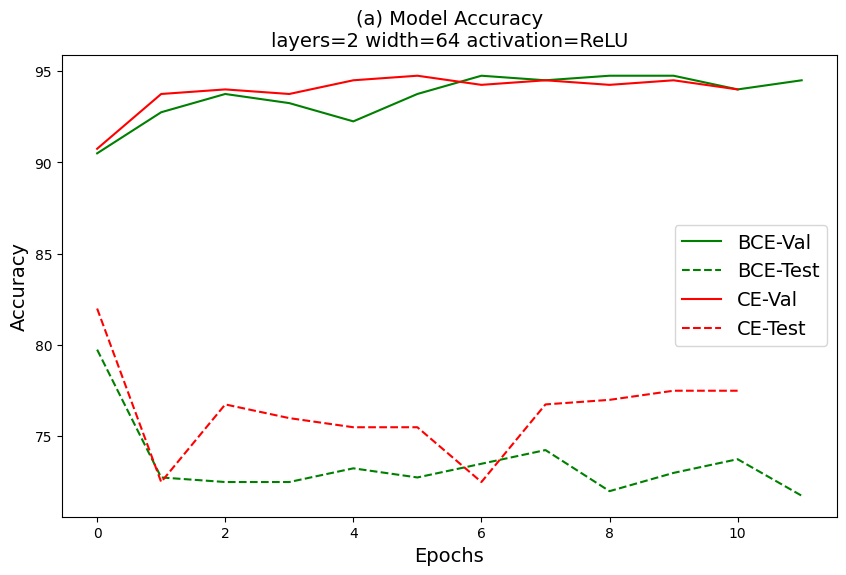

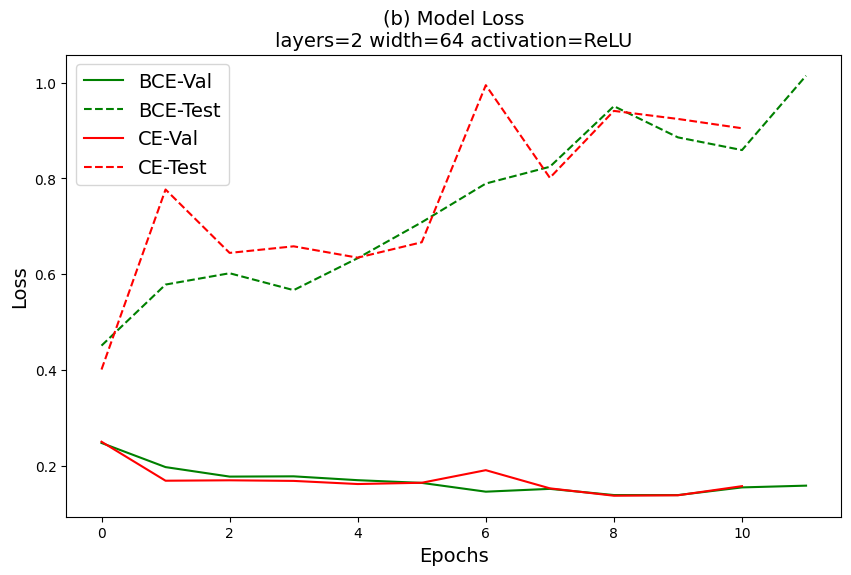

In [327]:
BCE_train_losses = []
BCE_train_accuracies = []
BCE_val_losses = []
BCE_val_accuracies = []
BCE_test_losses = []
BCE_test_accuracies = []

CE_train_losses = []
CE_train_accuracies = []
CE_val_losses = []
CE_val_accuracies = []
CE_test_losses = []
CE_test_accuracies = []

trials = 1
epochs = 30
# hyperparameters for early stop
patience = 2
epsilon = 0.02

# BCE loss

width = 64
layers = 2
activation = 'ReLU'
dropout = 0.0


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BCE_train_losses.append(train_losses)
    BCE_train_accuracies.append(train_accuracies)
    BCE_val_losses.append(val_losses)
    BCE_val_accuracies.append(val_accuracies)
    BCE_test_losses.append(test_losses)
    BCE_test_accuracies.append(test_accuracies)

    

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 2)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
    
train_loader, val_loader = data_loader(two_d_output=True)
test_loader = test_data_loader(two_d_output=True)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='CE')
    
    CE_train_losses.append(train_losses)
    CE_train_accuracies.append(train_accuracies)
    CE_val_losses.append(val_losses)
    CE_val_accuracies.append(val_accuracies)
    CE_test_losses.append(test_losses)
    CE_test_accuracies.append(test_accuracies)

    
    
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[0].plot(BCE_train_accuracies[i], color='r')
    ax.plot(BCE_val_accuracies[i], color='g')
    ax.plot(BCE_test_accuracies[i], color='g', linestyle='--')

    ax.plot(CE_val_accuracies[i], color='r')
    ax.plot(CE_test_accuracies[i], color='r', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_a_accuracies_L{layers}_W{width}_{activation}_T{trials}.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[1].plot(BCE_train_losses[i], color='r')
    ax.plot(BCE_val_losses[i], color='g')
    ax.plot(BCE_test_losses[i], color='g', linestyle='--')

    ax.plot(CE_val_losses[i], color='r')
    ax.plot(CE_test_losses[i], color='r', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_b_losses_L{layers}_W{width}_{activation}_T{trials}.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2642, Train Accu.: 88.75% Val Loss: 0.1805, Val Accu.: 94.00% Test Loss: 0.4471, Test Accu.: 80.00%
Epoch 2/30, Train Loss: 0.1732, Train Accu.: 92.81% Val Loss: 0.1504, Val Accu.: 93.50% Test Loss: 0.5926, Test Accu.: 76.00%
Epoch 3/30, Train Loss: 0.1512, Train Accu.: 94.25% V

Epoch 25/30, Train Loss: 0.0356, Train Accu.: 98.69% Val Loss: 0.2129, Val Accu.: 94.00% Test Loss: 0.9367, Test Accu.: 81.75%
Epoch 26/30, Train Loss: 0.0627, Train Accu.: 97.94% Val Loss: 0.1572, Val Accu.: 94.00% Test Loss: 1.2588, Test Accu.: 73.75%
Epoch 27/30, Train Loss: 0.0226, Train Accu.: 99.19% Val Loss: 0.1636, Val Accu.: 93.75% Test Loss: 1.2410, Test Accu.: 75.75%
Epoch 28/30, Train Loss: 0.0167, Train Accu.: 99.50% Val Loss: 0.1644, Val Accu.: 94.00% Test Loss: 1.1126, Test Accu.: 77.00%
Epoch 29/30, Train Loss: 0.0101, Train Accu.: 99.69% Val Loss: 0.1617, Val Accu.: 94.00% Test Loss: 1.2072, Test Accu.: 76.00%
Epoch 30/30, Train Loss: 0.0284, Train Accu.: 99.19% Val Loss: 0.2281, Val Accu.: 93.50% Test Loss: 1.0176, Test Accu.: 78.25%


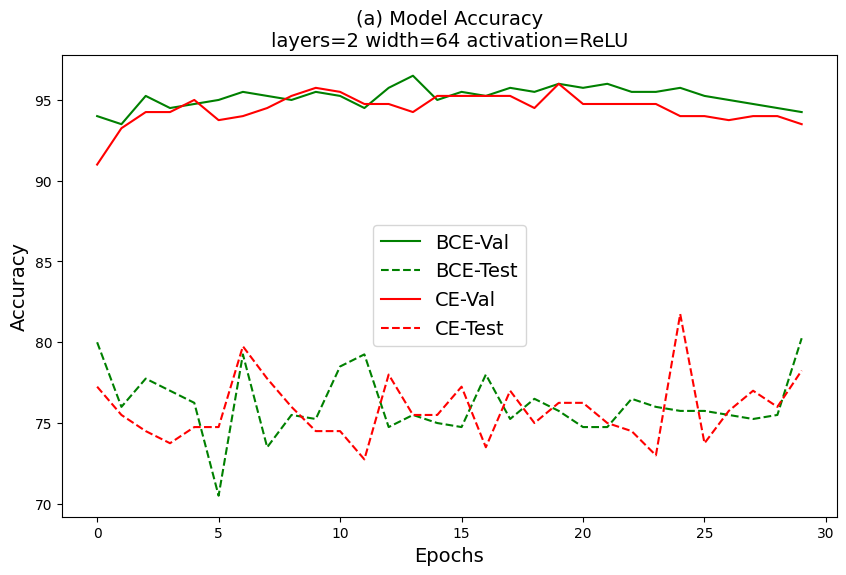

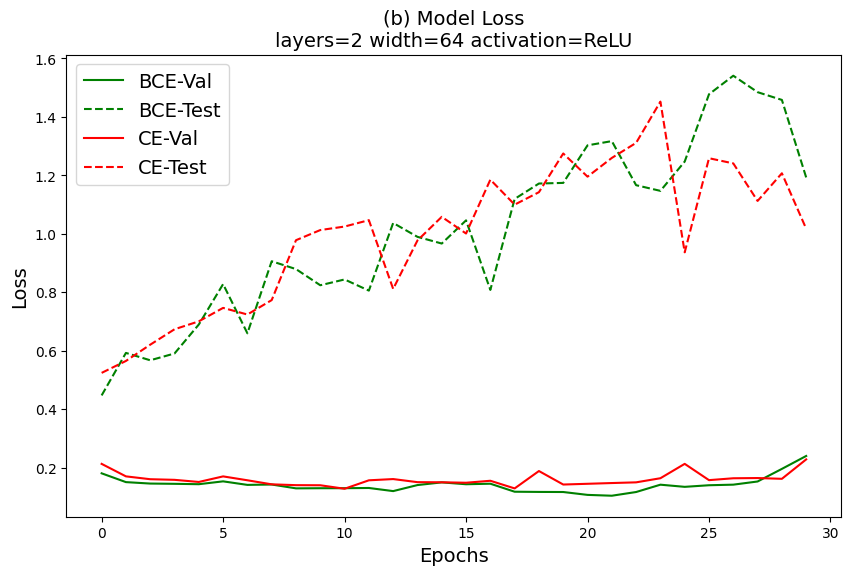

In [328]:
BCE_train_losses = []
BCE_train_accuracies = []
BCE_val_losses = []
BCE_val_accuracies = []
BCE_test_losses = []
BCE_test_accuracies = []

CE_train_losses = []
CE_train_accuracies = []
CE_val_losses = []
CE_val_accuracies = []
CE_test_losses = []
CE_test_accuracies = []

trials = 1
epochs = 30
# hyperparameters for early stop
patience = 5
epsilon = 0.001

# BCE loss

width = 64
layers = 2
activation = 'ReLU'
dropout = 0.0


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BCE_train_losses.append(train_losses)
    BCE_train_accuracies.append(train_accuracies)
    BCE_val_losses.append(val_losses)
    BCE_val_accuracies.append(val_accuracies)
    BCE_test_losses.append(test_losses)
    BCE_test_accuracies.append(test_accuracies)

    

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 2)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
    
train_loader, val_loader = data_loader(two_d_output=True)
test_loader = test_data_loader(two_d_output=True)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='CE')
    
    CE_train_losses.append(train_losses)
    CE_train_accuracies.append(train_accuracies)
    CE_val_losses.append(val_losses)
    CE_val_accuracies.append(val_accuracies)
    CE_test_losses.append(test_losses)
    CE_test_accuracies.append(test_accuracies)

    
    


# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[0].plot(BCE_train_accuracies[i], color='r')
    ax.plot(BCE_val_accuracies[i], color='g')
    ax.plot(BCE_test_accuracies[i], color='g', linestyle='--')

    ax.plot(CE_val_accuracies[i], color='r')
    ax.plot(CE_test_accuracies[i], color='r', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_no_early_stop.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[1].plot(BCE_train_losses[i], color='r')
    ax.plot(BCE_val_losses[i], color='g')
    ax.plot(BCE_test_losses[i], color='g', linestyle='--')

    ax.plot(CE_val_losses[i], color='r')
    ax.plot(CE_test_losses[i], color='r', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_b_losses_L{layers}_W{width}_{activation}_T{trials}_no_early_stop.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2873, Train Accu.: 87.00% Val Loss: 0.2083, Val Accu.: 92.25% Test Loss: 0.5274, Test Accu.: 76.75%
Epoch 2/30, Train Loss: 0.1798, Train Accu.: 93.44% Val Loss: 0.1655, Val Accu.: 94.00% Test Loss: 0.5979, Test Accu.: 75.50%
Epoch 3/30, Train Loss: 0.1401, Train Accu.: 94.94% V

Epoch 4/30, Train Loss: 0.0013, Train Accu.: 100.00% Val Loss: 0.1926, Val Accu.: 94.75% Test Loss: 1.8414, Test Accu.: 73.75%
Early stopping after no improvement.
Epoch 1/30, Train Loss: 0.0139, Train Accu.: 99.38% Val Loss: 0.2789, Val Accu.: 94.25% Test Loss: 1.6892, Test Accu.: 78.50%
Epoch 2/30, Train Loss: 0.0124, Train Accu.: 99.44% Val Loss: 0.2428, Val Accu.: 95.50% Test Loss: 2.1021, Test Accu.: 76.75%
Epoch 3/30, Train Loss: 0.0099, Train Accu.: 99.69% Val Loss: 0.2426, Val Accu.: 94.75% Test Loss: 2.2155, Test Accu.: 75.50%
Epoch 4/30, Train Loss: 0.0028, Train Accu.: 99.94% Val Loss: 0.2469, Val Accu.: 94.75% Test Loss: 1.9601, Test Accu.: 76.75%
Epoch 5/30, Train Loss: 0.0033, Train Accu.: 99.88% Val Loss: 0.2325, Val Accu.: 95.00% Test Loss: 2.0705, Test Accu.: 75.00%
Epoch 6/30, Train Loss: 0.0079, Train Accu.: 99.75% Val Loss: 0.2159, Val Accu.: 94.50% Test Loss: 1.5348, Test Accu.: 77.50%
Epoch 7/30, Train Loss: 0.0104, Train Accu.: 99.62% Val Loss: 0.2918, Val Accu.:

Epoch 12/30, Train Loss: 0.0575, Train Accu.: 98.25% Val Loss: 0.1240, Val Accu.: 96.00% Test Loss: 1.0783, Test Accu.: 76.00%
Epoch 13/30, Train Loss: 0.0664, Train Accu.: 97.50% Val Loss: 0.1785, Val Accu.: 95.00% Test Loss: 1.3730, Test Accu.: 74.75%
Epoch 14/30, Train Loss: 0.0543, Train Accu.: 98.19% Val Loss: 0.1633, Val Accu.: 95.25% Test Loss: 1.6834, Test Accu.: 73.25%
Epoch 15/30, Train Loss: 0.0337, Train Accu.: 98.69% Val Loss: 0.1400, Val Accu.: 95.50% Test Loss: 1.4075, Test Accu.: 75.25%
Epoch 16/30, Train Loss: 0.0272, Train Accu.: 99.19% Val Loss: 0.1410, Val Accu.: 94.75% Test Loss: 1.3102, Test Accu.: 76.00%
Early stopping after no improvement.
Epoch 1/30, Train Loss: 0.0868, Train Accu.: 96.69% Val Loss: 0.1916, Val Accu.: 93.50% Test Loss: 1.8671, Test Accu.: 68.50%
Epoch 2/30, Train Loss: 0.0481, Train Accu.: 98.00% Val Loss: 0.1933, Val Accu.: 94.25% Test Loss: 1.5812, Test Accu.: 71.25%
Epoch 3/30, Train Loss: 0.0277, Train Accu.: 99.06% Val Loss: 0.1400, Val Ac

Epoch 2/30, Train Loss: 0.0080, Train Accu.: 99.81% Val Loss: 0.3602, Val Accu.: 95.25% Test Loss: 3.1140, Test Accu.: 75.00%
Epoch 3/30, Train Loss: 0.0075, Train Accu.: 99.75% Val Loss: 0.2493, Val Accu.: 95.00% Test Loss: 3.2597, Test Accu.: 73.25%
Epoch 4/30, Train Loss: 0.0056, Train Accu.: 99.75% Val Loss: 0.2456, Val Accu.: 95.00% Test Loss: 3.0268, Test Accu.: 73.50%
Epoch 5/30, Train Loss: 0.0018, Train Accu.: 99.94% Val Loss: 0.3138, Val Accu.: 95.00% Test Loss: 3.3521, Test Accu.: 73.25%
Epoch 6/30, Train Loss: 0.0168, Train Accu.: 99.56% Val Loss: 0.2737, Val Accu.: 95.50% Test Loss: 2.4002, Test Accu.: 78.00%
Epoch 7/30, Train Loss: 0.0034, Train Accu.: 99.81% Val Loss: 0.3022, Val Accu.: 94.25% Test Loss: 2.2439, Test Accu.: 77.25%
Epoch 8/30, Train Loss: 0.0098, Train Accu.: 99.69% Val Loss: 0.2412, Val Accu.: 95.50% Test Loss: 2.6448, Test Accu.: 75.50%
Epoch 9/30, Train Loss: 0.0045, Train Accu.: 99.75% Val Loss: 0.2567, Val Accu.: 95.00% Test Loss: 2.8378, Test Accu.:

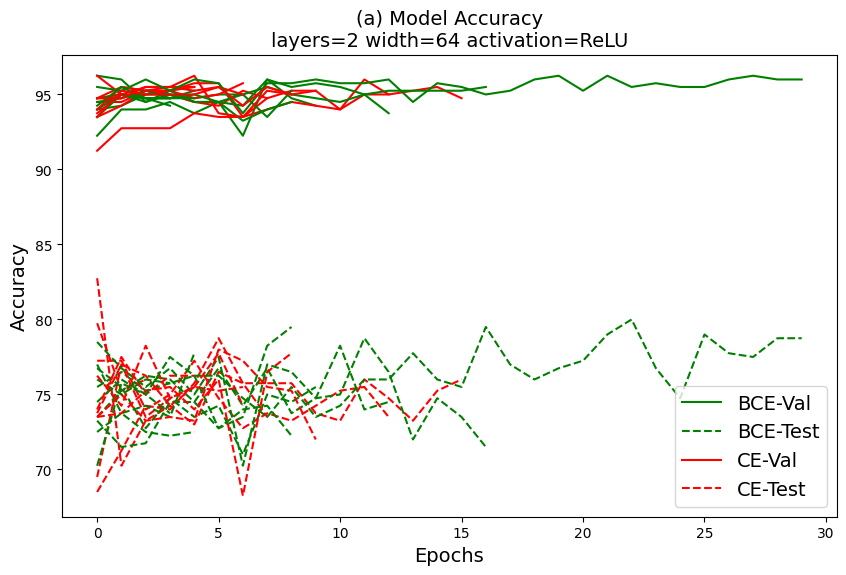

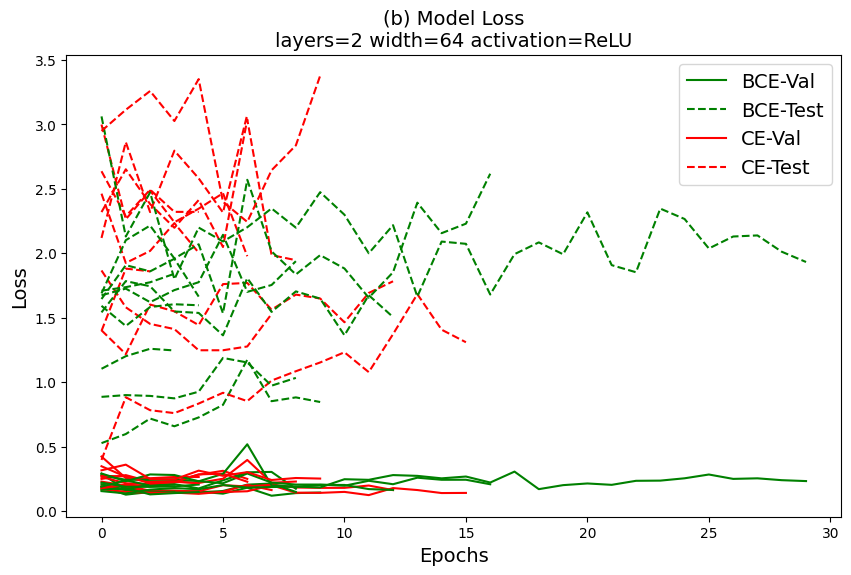

In [333]:
BCE_train_losses = []
BCE_train_accuracies = []
BCE_val_losses = []
BCE_val_accuracies = []
BCE_test_losses = []
BCE_test_accuracies = []

CE_train_losses = []
CE_train_accuracies = []
CE_val_losses = []
CE_val_accuracies = []
CE_test_losses = []
CE_test_accuracies = []

trials = 10
epochs = 30
# hyperparameters for early stop
patience = 2
epsilon = 0.03

# BCE loss

width = 64
layers = 2
activation = 'ReLU'
dropout = 0.0


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BCE_train_losses.append(train_losses)
    BCE_train_accuracies.append(train_accuracies)
    BCE_val_losses.append(val_losses)
    BCE_val_accuracies.append(val_accuracies)
    BCE_test_losses.append(test_losses)
    BCE_test_accuracies.append(test_accuracies)

    

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 2)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
    
train_loader, val_loader = data_loader(two_d_output=True)
test_loader = test_data_loader(two_d_output=True)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='CE')
    
    CE_train_losses.append(train_losses)
    CE_train_accuracies.append(train_accuracies)
    CE_val_losses.append(val_losses)
    CE_val_accuracies.append(val_accuracies)
    CE_test_losses.append(test_losses)
    CE_test_accuracies.append(test_accuracies)

    
    
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[0].plot(BCE_train_accuracies[i], color='r')
    ax.plot(BCE_val_accuracies[i], color='g')
    ax.plot(BCE_test_accuracies[i], color='g', linestyle='--')

    ax.plot(CE_val_accuracies[i], color='r')
    ax.plot(CE_test_accuracies[i], color='r', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[1].plot(BCE_train_losses[i], color='r')
    ax.plot(BCE_val_losses[i], color='g')
    ax.plot(BCE_test_losses[i], color='g', linestyle='--')

    ax.plot(CE_val_losses[i], color='r')
    ax.plot(CE_test_losses[i], color='r', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_b_losses_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.3193, Train Accu.: 86.69% Val Loss: 0.1856, Val Accu.: 94.00% Test Loss: 0.4467, Test Accu.: 83.00%
Epoch 2/30, Train Loss: 0.1598, Train Accu.: 93.75% Val Loss: 0.2056, Val Accu.: 93.00% Test Loss: 0.5621, Test Accu.: 76.50%
Epoch 3/30, Train Loss: 0.1379, Train Accu.: 94.50% V

Epoch 4/30, Train Loss: 0.0027, Train Accu.: 99.94% Val Loss: 0.1772, Val Accu.: 94.75% Test Loss: 2.1101, Test Accu.: 75.00%
Epoch 5/30, Train Loss: 0.0035, Train Accu.: 99.88% Val Loss: 0.1726, Val Accu.: 96.00% Test Loss: 2.5458, Test Accu.: 72.25%
Epoch 6/30, Train Loss: 0.0052, Train Accu.: 99.94% Val Loss: 0.3441, Val Accu.: 93.25% Test Loss: 2.2101, Test Accu.: 73.25%
Epoch 7/30, Train Loss: 0.0321, Train Accu.: 99.12% Val Loss: 0.3226, Val Accu.: 94.25% Test Loss: 2.0444, Test Accu.: 73.75%
Epoch 8/30, Train Loss: 0.0064, Train Accu.: 99.81% Val Loss: 0.2444, Val Accu.: 95.00% Test Loss: 2.2429, Test Accu.: 74.50%
Epoch 9/30, Train Loss: 0.0110, Train Accu.: 99.50% Val Loss: 0.2107, Val Accu.: 95.50% Test Loss: 2.0045, Test Accu.: 76.25%
Epoch 10/30, Train Loss: 0.0051, Train Accu.: 99.81% Val Loss: 0.2294, Val Accu.: 95.00% Test Loss: 1.9265, Test Accu.: 76.25%
Epoch 11/30, Train Loss: 0.0034, Train Accu.: 99.88% Val Loss: 0.2513, Val Accu.: 95.25% Test Loss: 1.9961, Test Accu

Epoch 5/30, Train Loss: 0.0007, Train Accu.: 99.94% Val Loss: 0.2618, Val Accu.: 94.25% Test Loss: 2.4459, Test Accu.: 75.75%
Epoch 6/30, Train Loss: 0.0002, Train Accu.: 100.00% Val Loss: 0.2750, Val Accu.: 95.00% Test Loss: 2.5771, Test Accu.: 74.25%
Epoch 7/30, Train Loss: 0.0117, Train Accu.: 99.56% Val Loss: 0.3203, Val Accu.: 95.50% Test Loss: 3.2360, Test Accu.: 71.50%
Epoch 8/30, Train Loss: 0.0238, Train Accu.: 99.44% Val Loss: 0.2776, Val Accu.: 93.25% Test Loss: 1.9893, Test Accu.: 76.25%
Epoch 9/30, Train Loss: 0.0032, Train Accu.: 99.88% Val Loss: 0.3346, Val Accu.: 93.50% Test Loss: 2.2242, Test Accu.: 74.75%
Epoch 10/30, Train Loss: 0.0077, Train Accu.: 99.81% Val Loss: 0.3333, Val Accu.: 94.00% Test Loss: 2.2058, Test Accu.: 75.50%
Epoch 11/30, Train Loss: 0.0111, Train Accu.: 99.69% Val Loss: 0.2675, Val Accu.: 93.50% Test Loss: 2.2096, Test Accu.: 75.75%
Early stopping after no improvement.
Epoch 1/30, Train Loss: 0.0131, Train Accu.: 99.56% Val Loss: 0.3301, Val Accu

Epoch 15/30, Train Loss: 0.0081, Train Accu.: 99.81% Val Loss: 0.2515, Val Accu.: 95.25% Test Loss: 2.9388, Test Accu.: 73.25%
Epoch 16/30, Train Loss: 0.0008, Train Accu.: 100.00% Val Loss: 0.2437, Val Accu.: 94.25% Test Loss: 2.6683, Test Accu.: 74.75%
Epoch 17/30, Train Loss: 0.0094, Train Accu.: 99.88% Val Loss: 0.1895, Val Accu.: 95.75% Test Loss: 2.7408, Test Accu.: 75.25%
Epoch 18/30, Train Loss: 0.0052, Train Accu.: 99.75% Val Loss: 0.2053, Val Accu.: 96.75% Test Loss: 3.1074, Test Accu.: 73.25%
Epoch 19/30, Train Loss: 0.0025, Train Accu.: 99.88% Val Loss: 0.2550, Val Accu.: 94.50% Test Loss: 2.3486, Test Accu.: 78.50%
Epoch 20/30, Train Loss: 0.0027, Train Accu.: 99.81% Val Loss: 0.1698, Val Accu.: 95.50% Test Loss: 3.1162, Test Accu.: 75.00%
Epoch 21/30, Train Loss: 0.0063, Train Accu.: 99.88% Val Loss: 0.1877, Val Accu.: 95.75% Test Loss: 3.0068, Test Accu.: 74.75%
Epoch 22/30, Train Loss: 0.0015, Train Accu.: 99.94% Val Loss: 0.1863, Val Accu.: 95.75% Test Loss: 2.9451, Te

Epoch 29/30, Train Loss: 0.0021, Train Accu.: 99.88% Val Loss: 0.2418, Val Accu.: 96.25% Test Loss: 3.3764, Test Accu.: 72.50%
Epoch 30/30, Train Loss: 0.0009, Train Accu.: 100.00% Val Loss: 0.2895, Val Accu.: 96.00% Test Loss: 2.8694, Test Accu.: 74.75%
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=2, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2923, Train Accu.: 88.00

Epoch 1/30, Train Loss: 0.0173, Train Accu.: 99.38% Val Loss: 0.4023, Val Accu.: 94.25% Test Loss: 2.4602, Test Accu.: 74.50%
Epoch 2/30, Train Loss: 0.0094, Train Accu.: 99.62% Val Loss: 0.3009, Val Accu.: 95.25% Test Loss: 2.0201, Test Accu.: 77.25%
Epoch 3/30, Train Loss: 0.0024, Train Accu.: 100.00% Val Loss: 0.2681, Val Accu.: 94.75% Test Loss: 1.9508, Test Accu.: 77.75%
Epoch 4/30, Train Loss: 0.0181, Train Accu.: 99.31% Val Loss: 0.2686, Val Accu.: 94.50% Test Loss: 2.0209, Test Accu.: 77.75%
Epoch 5/30, Train Loss: 0.0016, Train Accu.: 100.00% Val Loss: 0.2823, Val Accu.: 95.25% Test Loss: 1.8167, Test Accu.: 78.25%
Early stopping after no improvement.
Epoch 1/30, Train Loss: 0.0125, Train Accu.: 99.50% Val Loss: 0.3256, Val Accu.: 95.25% Test Loss: 2.0645, Test Accu.: 74.25%
Epoch 2/30, Train Loss: 0.0073, Train Accu.: 99.69% Val Loss: 0.3114, Val Accu.: 94.25% Test Loss: 2.3984, Test Accu.: 73.00%
Epoch 3/30, Train Loss: 0.0156, Train Accu.: 99.56% Val Loss: 0.3144, Val Accu.

Epoch 21/30, Train Loss: 0.0066, Train Accu.: 99.56% Val Loss: 0.3251, Val Accu.: 94.50% Test Loss: 3.3290, Test Accu.: 74.00%
Epoch 22/30, Train Loss: 0.0092, Train Accu.: 99.81% Val Loss: 0.3435, Val Accu.: 94.75% Test Loss: 3.0721, Test Accu.: 74.50%
Epoch 23/30, Train Loss: 0.0008, Train Accu.: 99.94% Val Loss: 0.2937, Val Accu.: 94.50% Test Loss: 2.9302, Test Accu.: 74.50%
Epoch 24/30, Train Loss: 0.0074, Train Accu.: 99.81% Val Loss: 0.3726, Val Accu.: 94.50% Test Loss: 2.8496, Test Accu.: 76.25%
Epoch 25/30, Train Loss: 0.0447, Train Accu.: 98.94% Val Loss: 0.4010, Val Accu.: 93.25% Test Loss: 2.0558, Test Accu.: 77.25%
Epoch 26/30, Train Loss: 0.0132, Train Accu.: 99.44% Val Loss: 0.2394, Val Accu.: 95.50% Test Loss: 2.6734, Test Accu.: 74.50%
Epoch 27/30, Train Loss: 0.0053, Train Accu.: 99.81% Val Loss: 0.2204, Val Accu.: 96.50% Test Loss: 2.7917, Test Accu.: 74.75%
Early stopping after no improvement.
Epoch 1/30, Train Loss: 0.0007, Train Accu.: 100.00% Val Loss: 0.2112, Val

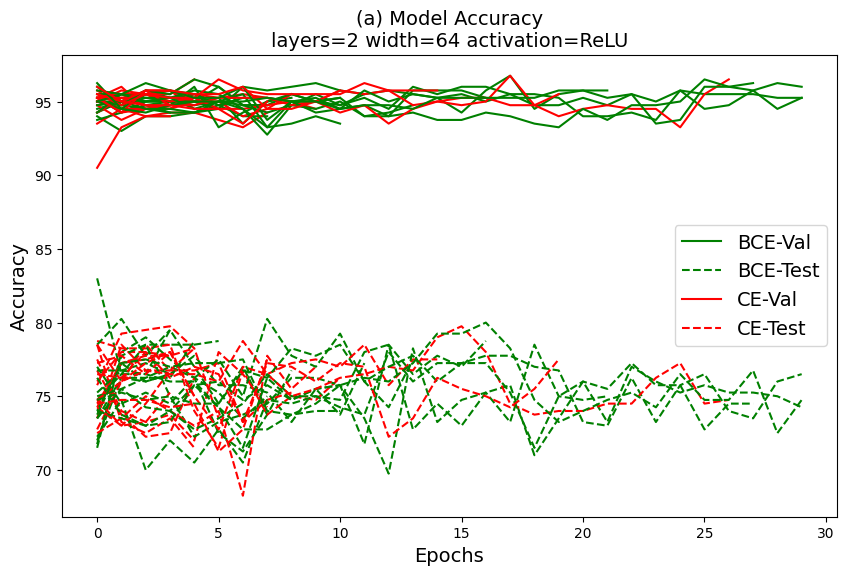

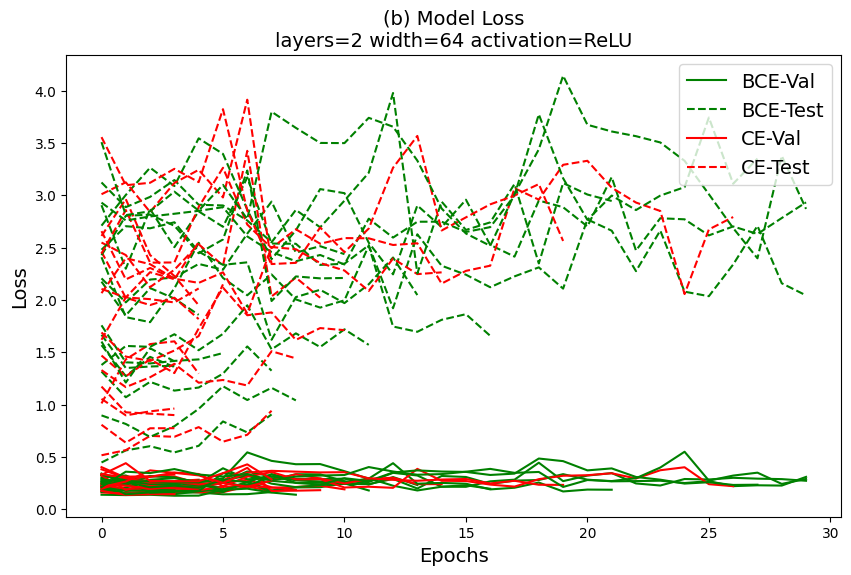

In [331]:
BCE_train_losses = []
BCE_train_accuracies = []
BCE_val_losses = []
BCE_val_accuracies = []
BCE_test_losses = []
BCE_test_accuracies = []

CE_train_losses = []
CE_train_accuracies = []
CE_val_losses = []
CE_val_accuracies = []
CE_test_losses = []
CE_test_accuracies = []

trials = 18
epochs = 30
# hyperparameters for early stop
patience = 2
epsilon = 0.03

# BCE loss

width = 64
layers = 2
activation = 'ReLU'
dropout = 0.0


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BCE_train_losses.append(train_losses)
    BCE_train_accuracies.append(train_accuracies)
    BCE_val_losses.append(val_losses)
    BCE_val_accuracies.append(val_accuracies)
    BCE_test_losses.append(test_losses)
    BCE_test_accuracies.append(test_accuracies)

    

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 2)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
    
train_loader, val_loader = data_loader(two_d_output=True)
test_loader = test_data_loader(two_d_output=True)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='CE')
    
    CE_train_losses.append(train_losses)
    CE_train_accuracies.append(train_accuracies)
    CE_val_losses.append(val_losses)
    CE_val_accuracies.append(val_accuracies)
    CE_test_losses.append(test_losses)
    CE_test_accuracies.append(test_accuracies)

    
    
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[0].plot(BCE_train_accuracies[i], color='r')
    ax.plot(BCE_val_accuracies[i], color='g')
    ax.plot(BCE_test_accuracies[i], color='g', linestyle='--')

    ax.plot(CE_val_accuracies[i], color='r')
    ax.plot(CE_test_accuracies[i], color='r', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_a_accuracies_L{layers}_W{width}_{activation}_T{trials}.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
#     ax[1].plot(BCE_train_losses[i], color='r')
    ax.plot(BCE_val_losses[i], color='g')
    ax.plot(BCE_test_losses[i], color='g', linestyle='--')

    ax.plot(CE_val_losses[i], color='r')
    ax.plot(CE_test_losses[i], color='r', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} width={width} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BCE-Val', 'BCE-Test', 'CE-Val', 'CE-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_BCE_and_CE_b_losses_L{layers}_W{width}_{activation}_T{trials}.png')

plt.show()

### Compare different hyperparameters

### hiden layer width: 8, 64, 512

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=4, bias=True)
  (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Mish()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=4, out_features=4, bias=True)
  (7): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Mish()
  (9): Dropout(p=0.0, inplace=False)
  (10): Linear(in_features=4, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.4709, Train Accu.: 81.38% Val Loss: 0.3583, Val Accu.: 90.50% Test Loss: 0.6045, Test Ac

Epoch 22/30, Train Loss: 0.0199, Train Accu.: 99.12% Val Loss: 0.1649, Val Accu.: 94.25% Test Loss: 1.3715, Test Accu.: 73.50%
Epoch 23/30, Train Loss: 0.0207, Train Accu.: 99.38% Val Loss: 0.1602, Val Accu.: 95.75% Test Loss: 1.2151, Test Accu.: 77.25%
Epoch 24/30, Train Loss: 0.0171, Train Accu.: 99.62% Val Loss: 0.1900, Val Accu.: 94.75% Test Loss: 1.2749, Test Accu.: 77.25%
Epoch 25/30, Train Loss: 0.0519, Train Accu.: 98.31% Val Loss: 0.1896, Val Accu.: 94.50% Test Loss: 0.9812, Test Accu.: 78.25%
Epoch 26/30, Train Loss: 0.0394, Train Accu.: 98.62% Val Loss: 0.2288, Val Accu.: 93.75% Test Loss: 0.9689, Test Accu.: 77.75%
Epoch 27/30, Train Loss: 0.0168, Train Accu.: 99.38% Val Loss: 0.1612, Val Accu.: 95.25% Test Loss: 1.3019, Test Accu.: 75.25%
Epoch 28/30, Train Loss: 0.0131, Train Accu.: 99.62% Val Loss: 0.1637, Val Accu.: 95.00% Test Loss: 1.2524, Test Accu.: 75.75%
Epoch 29/30, Train Loss: 0.0127, Train Accu.: 99.44% Val Loss: 0.1801, Val Accu.: 94.00% Test Loss: 1.2561, Tes

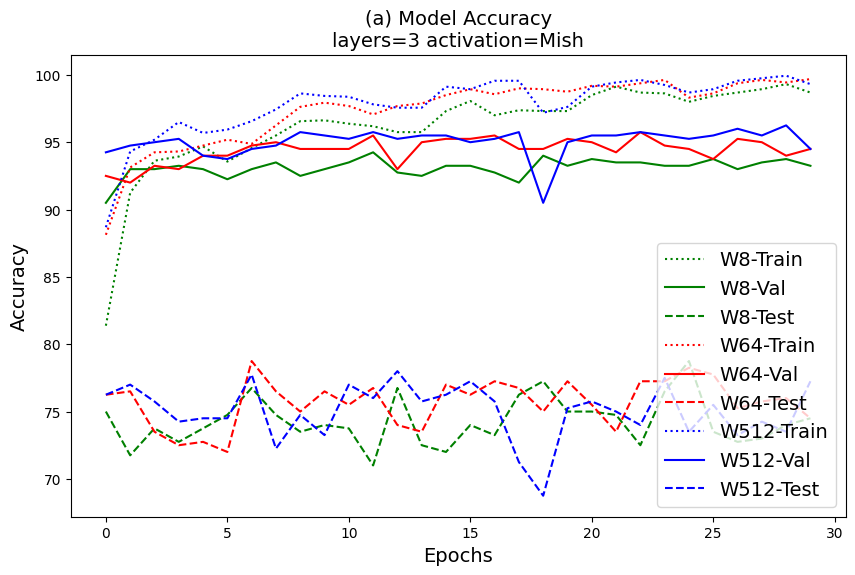

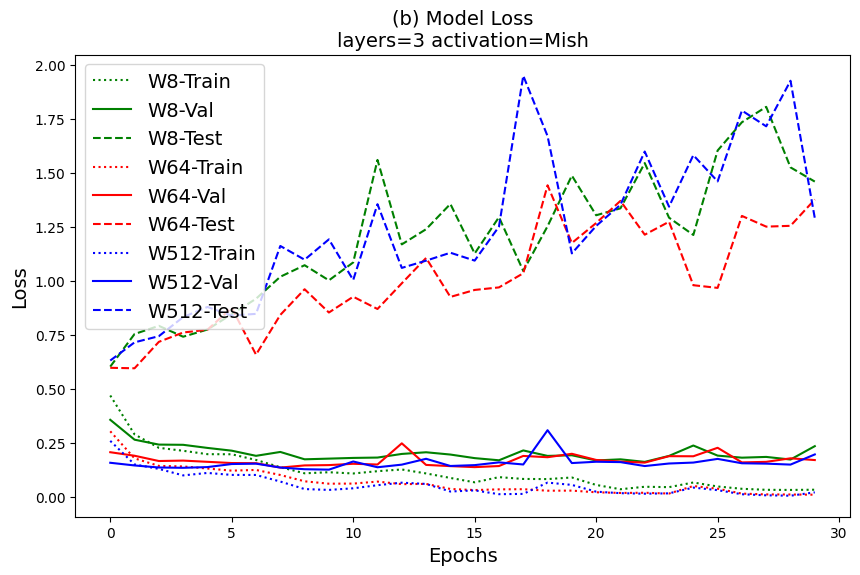

In [341]:
W8_train_losses = []
W8_train_accuracies = []
W8_val_losses = []
W8_val_accuracies = []
W8_test_losses = []
W8_test_accuracies = []

W64_train_losses = []
W64_train_accuracies = []
W64_val_losses = []
W64_val_accuracies = []
W64_test_losses = []
W64_test_accuracies = []

W512_train_losses = []
W512_train_accuracies = []
W512_val_losses = []
W512_val_accuracies = []
W512_test_losses = []
W512_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 5
epsilon = 0.0001


layers = 3
activation = 'Mish'  #'ReLU'
dropout = 0.0


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# width=8
width = 4

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    Mish(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    Mish(), 
    nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W8_train_losses.append(train_losses)
    W8_train_accuracies.append(train_accuracies)
    W8_val_losses.append(val_losses)
    W8_val_accuracies.append(val_accuracies)
    W8_test_losses.append(test_losses)
    W8_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# width=64
width = 16

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    Mish(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    Mish(), 
    nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W64_train_losses.append(train_losses)
    W64_train_accuracies.append(train_accuracies)
    W64_val_losses.append(val_losses)
    W64_val_accuracies.append(val_accuracies)
    W64_test_losses.append(test_losses)
    W64_test_accuracies.append(test_accuracies)


# ======================================================================================================
# width=512
width = 64

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    Mish(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, width), 
    nn.BatchNorm1d(width),
    Mish(), 
    nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W512_train_losses.append(train_losses)
    W512_train_accuracies.append(train_accuracies)
    W512_val_losses.append(val_losses)
    W512_val_accuracies.append(val_accuracies)
    W512_test_losses.append(test_losses)
    W512_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(W8_train_accuracies[i], color='g', linestyle=':')
    ax.plot(W8_val_accuracies[i], color='g')
    ax.plot(W8_test_accuracies[i], color='g', linestyle='--')

    ax.plot(W64_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(W64_val_accuracies[i], color='r')
    ax.plot(W64_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(W512_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(W512_val_accuracies[i], color='b')
    ax.plot(W512_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['W8-Train', 'W8-Val', 'W8-Test', 'W64-Train', 'W64-Val', 'W64-Test', 'W512-Train', 'W512-Val', 'W512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_width_a_accuracies_L{layers}_W8_W64_W512_{activation}_T{trials}_E{epsilon}.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(W8_train_losses[i], color='g', linestyle=':')
    ax.plot(W8_val_losses[i], color='g')
    ax.plot(W8_test_losses[i], color='g', linestyle='--')

    ax.plot(W64_train_losses[i], color='r', linestyle=':')    
    ax.plot(W64_val_losses[i], color='r')
    ax.plot(W64_test_losses[i], color='r', linestyle='--')
    
    ax.plot(W512_train_losses[i], color='b', linestyle=':')    
    ax.plot(W512_val_losses[i], color='b')
    ax.plot(W512_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['W8-Train', 'W8-Val', 'W8-Test', 'W64-Train', 'W64-Val', 'W64-Test', 'W512-Train', 'W512-Val', 'W512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_width_b_losses_L{layers}_W8_W64_W512_{activation}_T{trials}_E{epsilon}.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=8, bias=True)
  (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=8, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.5104, Train Accu.: 75.62% Val Loss: 0.3470, Val Accu.: 86.75% Test Loss: 0.4630, Test Accu.: 78.25%
Epoch 2/30, Train Loss: 0.3705, Train Accu.: 85.81% Val Loss: 0.2563, Val Accu.: 91.25% Test Loss: 0.4336, Test Accu.: 80.25%
Epoch 3/30, Train Loss: 0.3464, Train Accu.: 85.81% Val 

Epoch 25/30, Train Loss: 0.0701, Train Accu.: 97.69% Val Loss: 0.1713, Val Accu.: 95.00% Test Loss: 1.2838, Test Accu.: 72.50%
Epoch 26/30, Train Loss: 0.0651, Train Accu.: 97.69% Val Loss: 0.1496, Val Accu.: 95.50% Test Loss: 1.1353, Test Accu.: 75.75%
Epoch 27/30, Train Loss: 0.0602, Train Accu.: 97.69% Val Loss: 0.1574, Val Accu.: 95.25% Test Loss: 1.2563, Test Accu.: 74.50%
Epoch 28/30, Train Loss: 0.0486, Train Accu.: 98.38% Val Loss: 0.1615, Val Accu.: 95.00% Test Loss: 1.2129, Test Accu.: 74.75%
Epoch 29/30, Train Loss: 0.0541, Train Accu.: 98.00% Val Loss: 0.1462, Val Accu.: 95.00% Test Loss: 1.2614, Test Accu.: 76.50%
Epoch 30/30, Train Loss: 0.0369, Train Accu.: 98.75% Val Loss: 0.1596, Val Accu.: 95.75% Test Loss: 1.3457, Test Accu.: 74.75%
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=512, bias=True)
  (3): BatchNorm1d(512, eps=1e-05,

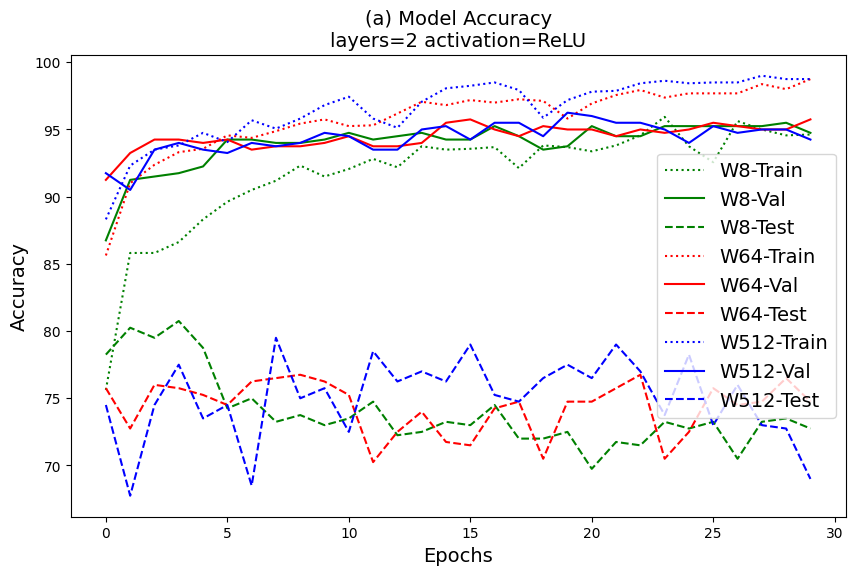

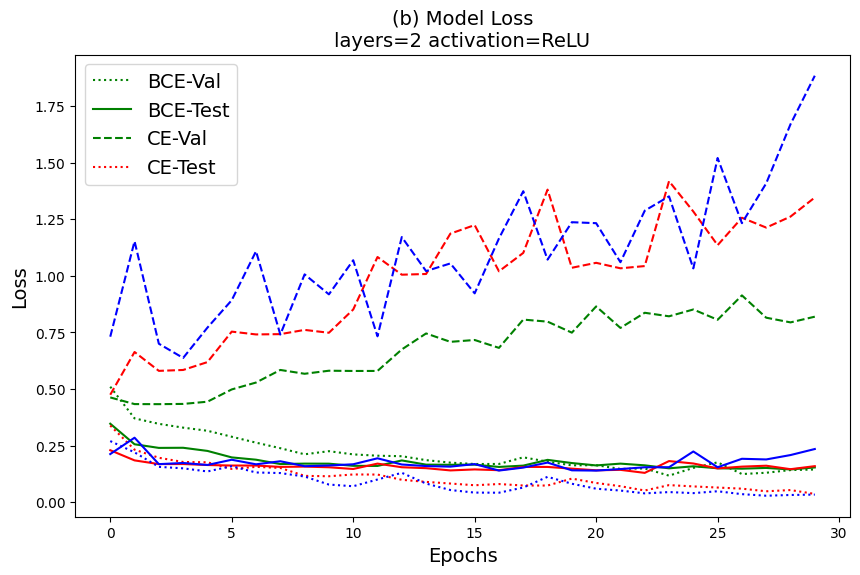

In [336]:
W8_train_losses = []
W8_train_accuracies = []
W8_val_losses = []
W8_val_accuracies = []
W8_test_losses = []
W8_test_accuracies = []

W64_train_losses = []
W64_train_accuracies = []
W64_val_losses = []
W64_val_accuracies = []
W64_test_losses = []
W64_test_accuracies = []

W512_train_losses = []
W512_train_accuracies = []
W512_val_losses = []
W512_val_accuracies = []
W512_test_losses = []
W512_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 5
epsilon = 0.0001


layers = 2
activation = 'ReLU'
dropout = 0.5


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# width=8
width = 8

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
#     nn.Linear(width, width), 
#     nn.BatchNorm1d(width),
#     nn.ReLU(), 
#     nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W8_train_losses.append(train_losses)
    W8_train_accuracies.append(train_accuracies)
    W8_val_losses.append(val_losses)
    W8_val_accuracies.append(val_accuracies)
    W8_test_losses.append(test_losses)
    W8_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# width=64
width = 64

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
#     nn.Linear(width, width), 
#     nn.BatchNorm1d(width),
#     nn.ReLU(), 
#     nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W64_train_losses.append(train_losses)
    W64_train_accuracies.append(train_accuracies)
    W64_val_losses.append(val_losses)
    W64_val_accuracies.append(val_accuracies)
    W64_test_losses.append(test_losses)
    W64_test_accuracies.append(test_accuracies)


# ======================================================================================================
# width=512
width = 512

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
#     nn.Linear(width, width), 
#     nn.BatchNorm1d(width),
#     nn.ReLU(), 
#     nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W512_train_losses.append(train_losses)
    W512_train_accuracies.append(train_accuracies)
    W512_val_losses.append(val_losses)
    W512_val_accuracies.append(val_accuracies)
    W512_test_losses.append(test_losses)
    W512_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(W8_train_accuracies[i], color='g', linestyle=':')
    ax.plot(W8_val_accuracies[i], color='g')
    ax.plot(W8_test_accuracies[i], color='g', linestyle='--')

    ax.plot(W64_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(W64_val_accuracies[i], color='r')
    ax.plot(W64_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(W512_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(W512_val_accuracies[i], color='b')
    ax.plot(W512_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['W8-Train', 'W8-Val', 'W8-Test', 'W64-Train', 'W64-Val', 'W64-Test', 'W512-Train', 'W512-Val', 'W512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_width_a_accuracies_L{layers}_W8_W64_W512_{activation}_T{trials}_E{epsilon}.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(W8_train_losses[i], color='g', linestyle=':')
    ax.plot(W8_val_losses[i], color='g')
    ax.plot(W8_test_losses[i], color='g', linestyle='--')

    ax.plot(W64_train_losses[i], color='r', linestyle=':')    
    ax.plot(W64_val_losses[i], color='r')
    ax.plot(W64_test_losses[i], color='r', linestyle='--')
    
    ax.plot(W512_train_losses[i], color='b', linestyle=':')    
    ax.plot(W512_val_losses[i], color='b')
    ax.plot(W512_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['W8-Train', 'W8-Val', 'W8-Test', 'W64-Train', 'W64-Val', 'W64-Test', 'W512-Train', 'W512-Val', 'W512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_width_b_losses_L{layers}_W8_W64_W512_{activation}_T{trials}_E{epsilon}.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=8, bias=True)
  (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=8, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.5271, Train Accu.: 75.38% Val Loss: 0.4044, Val Accu.: 84.50% Test Loss: 0.5165, Test Accu.: 74.00%
Epoch 2/30, Train Loss: 0.4210, Train Accu.: 81.94% Val Loss: 0.3260, Val Accu.: 88.00% Test Loss: 0.4823, Test Accu.: 73.75%
Epoch 3/30, Train Loss: 0.4016, Train Accu.: 81.19% Val 

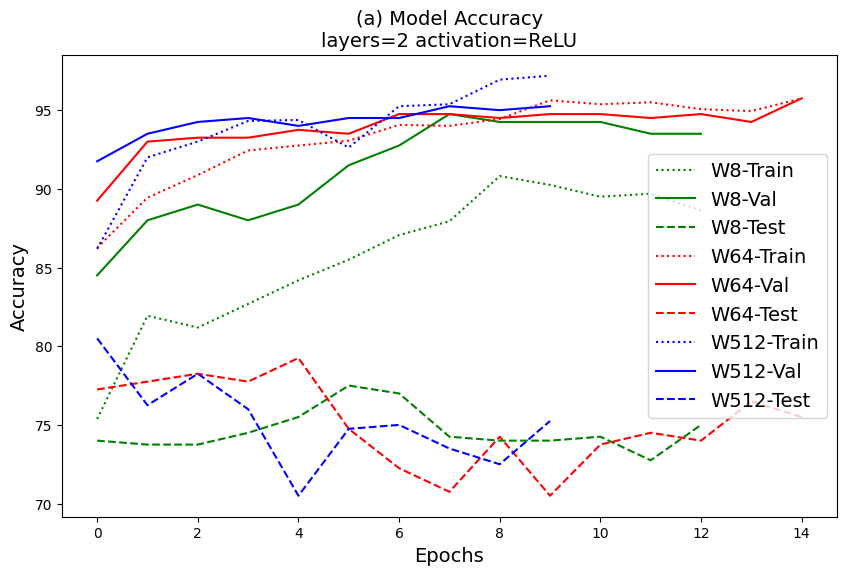

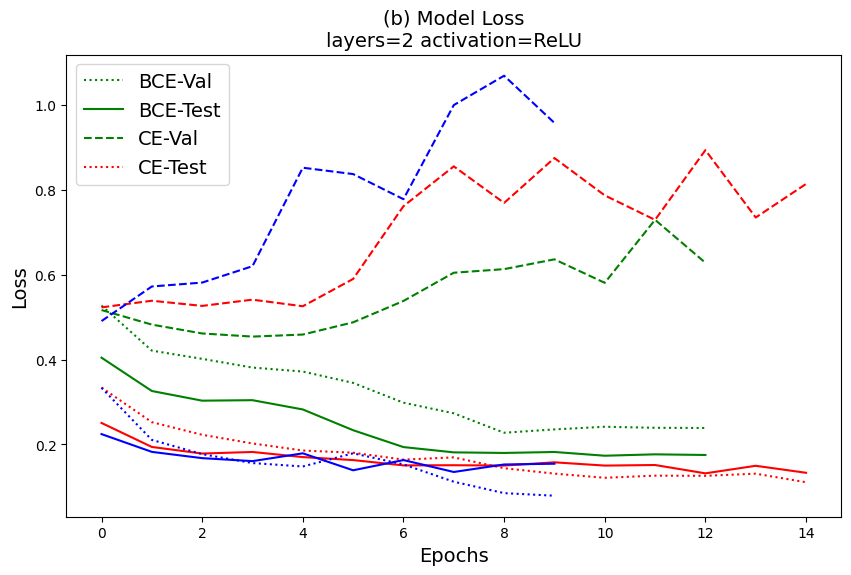

In [337]:
W8_train_losses = []
W8_train_accuracies = []
W8_val_losses = []
W8_val_accuracies = []
W8_test_losses = []
W8_test_accuracies = []

W64_train_losses = []
W64_train_accuracies = []
W64_val_losses = []
W64_val_accuracies = []
W64_test_losses = []
W64_test_accuracies = []

W512_train_losses = []
W512_train_accuracies = []
W512_val_losses = []
W512_val_accuracies = []
W512_test_losses = []
W512_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 2
epsilon = 0.03


layers = 2
activation = 'ReLU'
dropout = 0.5


# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# width=8
width = 8

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
#     nn.Linear(width, width), 
#     nn.BatchNorm1d(width),
#     nn.ReLU(), 
#     nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W8_train_losses.append(train_losses)
    W8_train_accuracies.append(train_accuracies)
    W8_val_losses.append(val_losses)
    W8_val_accuracies.append(val_accuracies)
    W8_test_losses.append(test_losses)
    W8_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# width=64
width = 64

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
#     nn.Linear(width, width), 
#     nn.BatchNorm1d(width),
#     nn.ReLU(), 
#     nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W64_train_losses.append(train_losses)
    W64_train_accuracies.append(train_accuracies)
    W64_val_losses.append(val_losses)
    W64_val_accuracies.append(val_accuracies)
    W64_test_losses.append(test_losses)
    W64_test_accuracies.append(test_accuracies)


# ======================================================================================================
# width=512
width = 512

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
#     nn.Linear(width, width), 
#     nn.BatchNorm1d(width),
#     nn.ReLU(), 
#     nn.Dropout(dropout), 
    
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    W512_train_losses.append(train_losses)
    W512_train_accuracies.append(train_accuracies)
    W512_val_losses.append(val_losses)
    W512_val_accuracies.append(val_accuracies)
    W512_test_losses.append(test_losses)
    W512_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(W8_train_accuracies[i], color='g', linestyle=':')
    ax.plot(W8_val_accuracies[i], color='g')
    ax.plot(W8_test_accuracies[i], color='g', linestyle='--')

    ax.plot(W64_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(W64_val_accuracies[i], color='r')
    ax.plot(W64_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(W512_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(W512_val_accuracies[i], color='b')
    ax.plot(W512_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['W8-Train', 'W8-Val', 'W8-Test', 'W64-Train', 'W64-Val', 'W64-Test', 'W512-Train', 'W512-Val', 'W512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_width_a_accuracies_L{layers}_W8_W64_W512_{activation}_T{trials}_E{epsilon}.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(W8_train_losses[i], color='g', linestyle=':')
    ax.plot(W8_val_losses[i], color='g')
    ax.plot(W8_test_losses[i], color='g', linestyle='--')

    ax.plot(W64_train_losses[i], color='r', linestyle=':')    
    ax.plot(W64_val_losses[i], color='r')
    ax.plot(W64_test_losses[i], color='r', linestyle='--')
    
    ax.plot(W512_train_losses[i], color='b', linestyle=':')    
    ax.plot(W512_val_losses[i], color='b')
    ax.plot(W512_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['W8-Train', 'W8-Val', 'W8-Test', 'W64-Train', 'W64-Val', 'W64-Test', 'W512-Train', 'W512-Val', 'W512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_width_b_losses_L{layers}_W8_W64_W512_{activation}_T{trials}_E{epsilon}.png')

plt.show()

### Dropout: 0, 0.25, 0.5

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2626, Train Accu.: 89.44% Val Loss: 0.2248, Val Accu.: 92.25% Test Loss: 0.6899, Test Accu.: 76.00%
Epoch 2/30, Train Loss: 0.2012, Train Accu.: 92.38% Val Loss: 0.1761, Val Accu.: 94.00% Test Loss: 0.6014, Test Accu.: 77.00%
Epoch 3/30, Train Loss: 0.1692, Train Accu.: 93.50% V

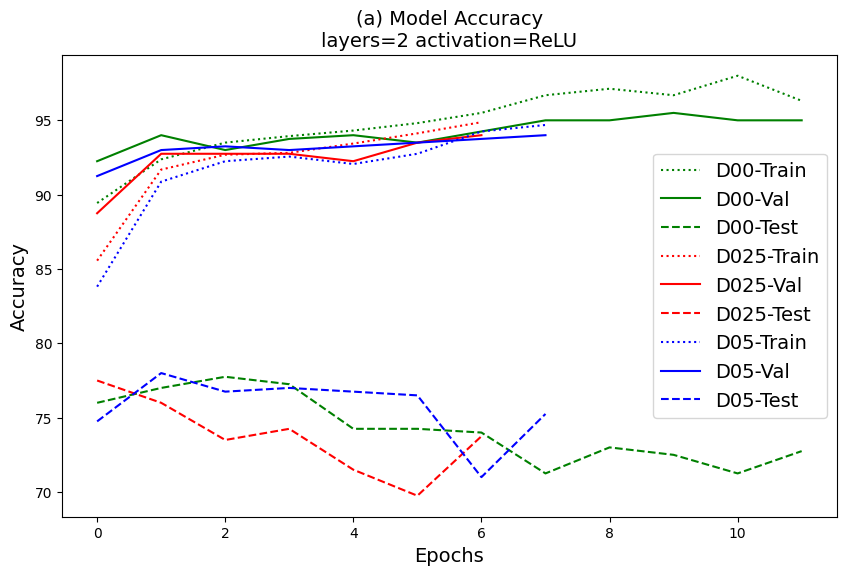

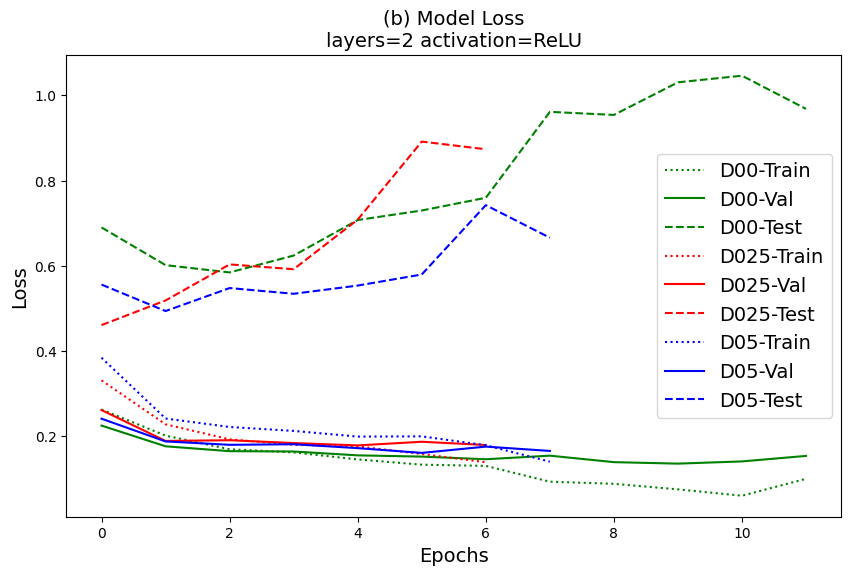

In [342]:
D00_train_losses = []
D00_train_accuracies = []
D00_val_losses = []
D00_val_accuracies = []
D00_test_losses = []
D00_test_accuracies = []

D025_train_losses = []
D025_train_accuracies = []
D025_val_losses = []
D025_val_accuracies = []
D025_test_losses = []
D025_test_accuracies = []

D05_train_losses = []
D05_train_accuracies = []
D05_val_losses = []
D05_val_accuracies = []
D05_test_losses = []
D05_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 2
epsilon = 0.03


layers = 2
activation = 'ReLU'

width = 64

# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# dropout = 0.0

dropout = 0.0

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    D00_train_losses.append(train_losses)
    D00_train_accuracies.append(train_accuracies)
    D00_val_losses.append(val_losses)
    D00_val_accuracies.append(val_accuracies)
    D00_test_losses.append(test_losses)
    D00_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# dropout = 0.25

dropout = 0.25

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()


print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    D025_train_losses.append(train_losses)
    D025_train_accuracies.append(train_accuracies)
    D025_val_losses.append(val_losses)
    D025_val_accuracies.append(val_accuracies)
    D025_test_losses.append(test_losses)
    D025_test_accuracies.append(test_accuracies)


# ======================================================================================================
# dropout = 0.5

dropout = 0.5

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    D05_train_losses.append(train_losses)
    D05_train_accuracies.append(train_accuracies)
    D05_val_losses.append(val_losses)
    D05_val_accuracies.append(val_accuracies)
    D05_test_losses.append(test_losses)
    D05_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(D00_train_accuracies[i], color='g', linestyle=':')
    ax.plot(D00_val_accuracies[i], color='g')
    ax.plot(D00_test_accuracies[i], color='g', linestyle='--')

    ax.plot(D025_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(D025_val_accuracies[i], color='r')
    ax.plot(D025_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(D05_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(D05_val_accuracies[i], color='b')
    ax.plot(D05_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['D00-Train', 'D00-Val', 'D00-Test', 'D025-Train', 'D025-Val', 'D025-Test', 'D05-Train', 'D05-Val', 'D05-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_dropout_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_D_0_025_05.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(D00_train_losses[i], color='g', linestyle=':')
    ax.plot(D00_val_losses[i], color='g')
    ax.plot(D00_test_losses[i], color='g', linestyle='--')

    ax.plot(D025_train_losses[i], color='r', linestyle=':')    
    ax.plot(D025_val_losses[i], color='r')
    ax.plot(D025_test_losses[i], color='r', linestyle='--')
    
    ax.plot(D05_train_losses[i], color='b', linestyle=':')    
    ax.plot(D05_val_losses[i], color='b')
    ax.plot(D05_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['D00-Train', 'D00-Val', 'D00-Test', 'D025-Train', 'D025-Val', 'D025-Test', 'D05-Train', 'D05-Val', 'D05-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_dropout_b_losses_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_D_0_025_05.png')

plt.show()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2735, Train Accu.: 88.25% Val Loss: 0.1993, Val Accu.: 92.25% Test Loss: 0.5470, Test Accu.: 75.75%
Epoch 2/30, Train Loss: 0.1593, Train Accu.: 93.69% Val Loss: 0.1719, Val Accu.: 93.75% Test Loss: 0.7146, Test Accu.: 73.25%
Epoch 3/30, Train Loss: 0.1467, Train Accu.: 94.44% V

Epoch 25/30, Train Loss: 0.0610, Train Accu.: 97.44% Val Loss: 0.1587, Val Accu.: 93.75% Test Loss: 1.2025, Test Accu.: 73.00%
Epoch 26/30, Train Loss: 0.0598, Train Accu.: 97.62% Val Loss: 0.1805, Val Accu.: 94.25% Test Loss: 1.4400, Test Accu.: 73.75%
Epoch 27/30, Train Loss: 0.0368, Train Accu.: 98.75% Val Loss: 0.1555, Val Accu.: 95.50% Test Loss: 1.4044, Test Accu.: 75.00%
Epoch 28/30, Train Loss: 0.0382, Train Accu.: 98.75% Val Loss: 0.1572, Val Accu.: 95.00% Test Loss: 1.2531, Test Accu.: 77.00%
Epoch 29/30, Train Loss: 0.0319, Train Accu.: 98.94% Val Loss: 0.1469, Val Accu.: 95.75% Test Loss: 1.3158, Test Accu.: 76.00%
Epoch 30/30, Train Loss: 0.0373, Train Accu.: 98.81% Val Loss: 0.1526, Val Accu.: 94.75% Test Loss: 1.2537, Test Accu.: 76.50%
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, m

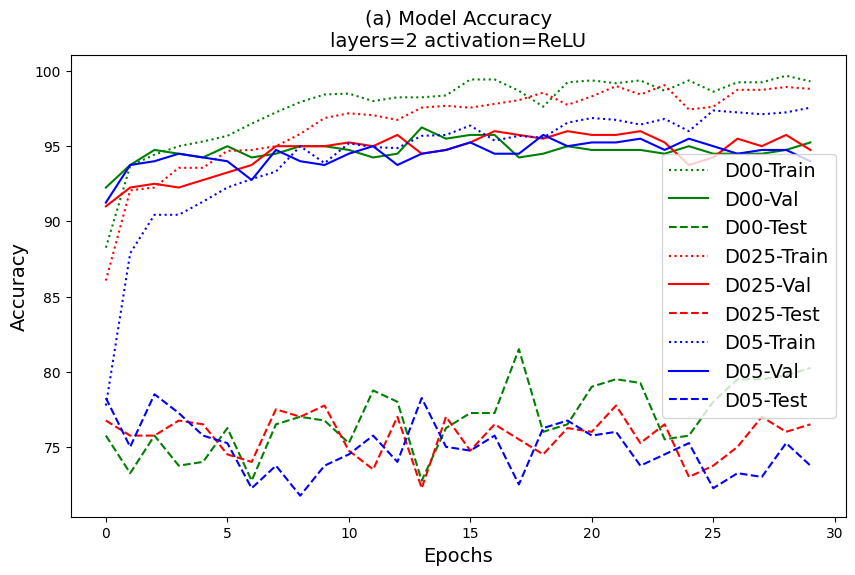

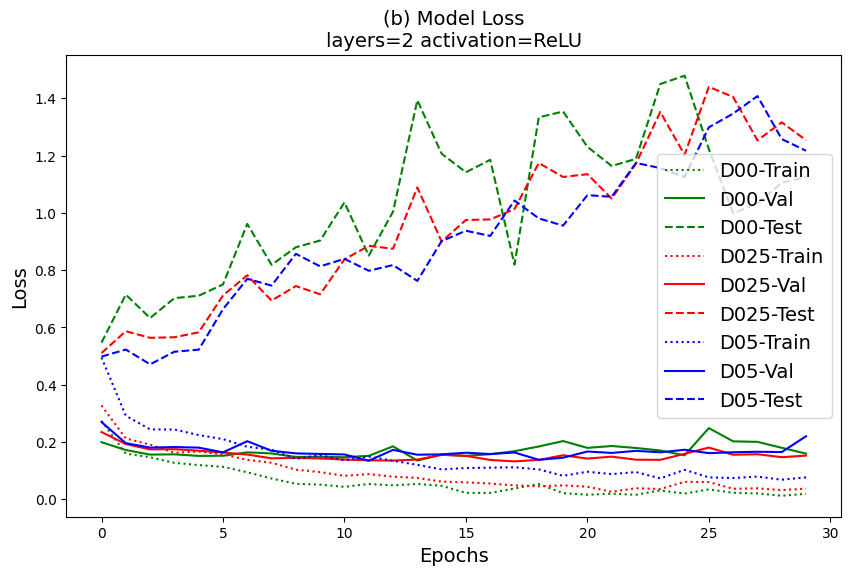

In [354]:
D00_train_losses = []
D00_train_accuracies = []
D00_val_losses = []
D00_val_accuracies = []
D00_test_losses = []
D00_test_accuracies = []

D025_train_losses = []
D025_train_accuracies = []
D025_val_losses = []
D025_val_accuracies = []
D025_test_losses = []
D025_test_accuracies = []

D05_train_losses = []
D05_train_accuracies = []
D05_val_losses = []
D05_val_accuracies = []
D05_test_losses = []
D05_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 3
epsilon = 0.0001


layers = 2
activation = 'ReLU'

width = 64

# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# dropout = 0.0

dropout = 0.0

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    D00_train_losses.append(train_losses)
    D00_train_accuracies.append(train_accuracies)
    D00_val_losses.append(val_losses)
    D00_val_accuracies.append(val_accuracies)
    D00_test_losses.append(test_losses)
    D00_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# dropout = 0.25

dropout = 0.25

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()


print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    D025_train_losses.append(train_losses)
    D025_train_accuracies.append(train_accuracies)
    D025_val_losses.append(val_losses)
    D025_val_accuracies.append(val_accuracies)
    D025_test_losses.append(test_losses)
    D025_test_accuracies.append(test_accuracies)


# ======================================================================================================
# dropout = 0.5

dropout = 0.5

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False)
test_loader = test_data_loader(two_d_output=False)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    D05_train_losses.append(train_losses)
    D05_train_accuracies.append(train_accuracies)
    D05_val_losses.append(val_losses)
    D05_val_accuracies.append(val_accuracies)
    D05_test_losses.append(test_losses)
    D05_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(D00_train_accuracies[i], color='g', linestyle=':')
    ax.plot(D00_val_accuracies[i], color='g')
    ax.plot(D00_test_accuracies[i], color='g', linestyle='--')

    ax.plot(D025_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(D025_val_accuracies[i], color='r')
    ax.plot(D025_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(D05_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(D05_val_accuracies[i], color='b')
    ax.plot(D05_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['D00-Train', 'D00-Val', 'D00-Test', 'D025-Train', 'D025-Val', 'D025-Test', 'D05-Train', 'D05-Val', 'D05-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_dropout_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_D_0_025_05.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(D00_train_losses[i], color='g', linestyle=':')
    ax.plot(D00_val_losses[i], color='g')
    ax.plot(D00_test_losses[i], color='g', linestyle='--')

    ax.plot(D025_train_losses[i], color='r', linestyle=':')    
    ax.plot(D025_val_losses[i], color='r')
    ax.plot(D025_test_losses[i], color='r', linestyle='--')
    
    ax.plot(D05_train_losses[i], color='b', linestyle=':')    
    ax.plot(D05_val_losses[i], color='b')
    ax.plot(D05_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['D00-Train', 'D00-Val', 'D00-Test', 'D025-Train', 'D025-Val', 'D025-Test', 'D05-Train', 'D05-Val', 'D05-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_dropout_b_losses_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_D_0_025_05.png')

plt.show()

### batch_size 1, 32, 400

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LayerNorm((65536,), eps=1e-05, elementwise_affine=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2962, Train Accu.: 87.81% Val Loss: 0.1986, Val Accu.: 92.00% Test Loss: 1.0677, Test Accu.: 68.50%
Epoch 2/30, Train Loss: 0.1678, Train Accu.: 93.62% Val Loss: 0.2484, Val Accu.: 90.25% Test Loss: 0.7661, Test Accu.: 74.00%
Epoch 3/30, Train Loss: 0.0861, Train Accu.: 96.88% Val Loss: 0.1874, Val Accu.: 94.25% Test Loss: 0.8849, 

Epoch 9/30, Train Loss: 0.2119, Train Accu.: 91.50% Val Loss: 0.2312, Val Accu.: 91.50% Test Loss: 0.4708, Test Accu.: 78.00%
Epoch 10/30, Train Loss: 0.2108, Train Accu.: 91.88% Val Loss: 0.2315, Val Accu.: 91.25% Test Loss: 0.4698, Test Accu.: 78.00%
Epoch 11/30, Train Loss: 0.2084, Train Accu.: 91.69% Val Loss: 0.2272, Val Accu.: 91.75% Test Loss: 0.4708, Test Accu.: 78.25%
Epoch 12/30, Train Loss: 0.1962, Train Accu.: 92.44% Val Loss: 0.2132, Val Accu.: 92.25% Test Loss: 0.4780, Test Accu.: 77.25%
Epoch 13/30, Train Loss: 0.1830, Train Accu.: 92.88% Val Loss: 0.1973, Val Accu.: 93.75% Test Loss: 0.4936, Test Accu.: 76.00%
Epoch 14/30, Train Loss: 0.1624, Train Accu.: 93.75% Val Loss: 0.1887, Val Accu.: 93.75% Test Loss: 0.5145, Test Accu.: 74.75%
Epoch 15/30, Train Loss: 0.1524, Train Accu.: 94.25% Val Loss: 0.1867, Val Accu.: 93.75% Test Loss: 0.5229, Test Accu.: 75.25%
Epoch 16/30, Train Loss: 0.1506, Train Accu.: 94.25% Val Loss: 0.1872, Val Accu.: 93.75% Test Loss: 0.5214, Test

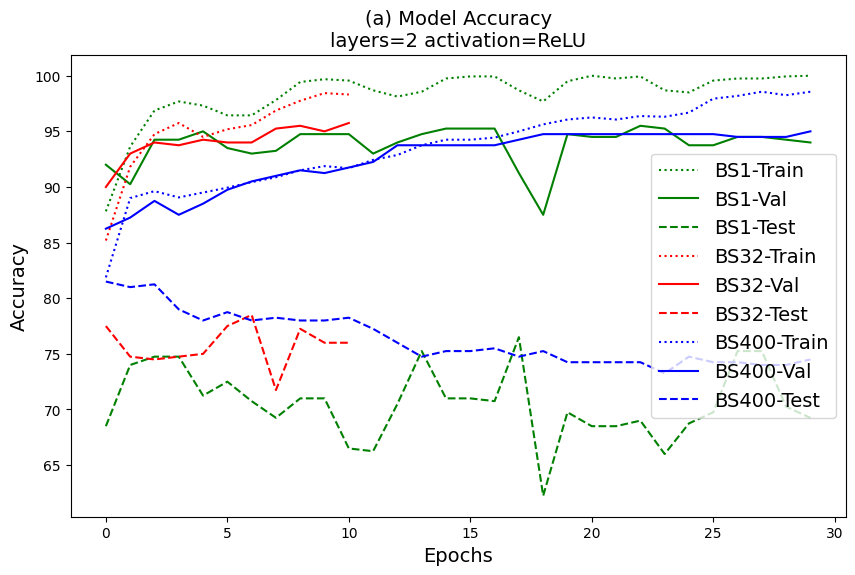

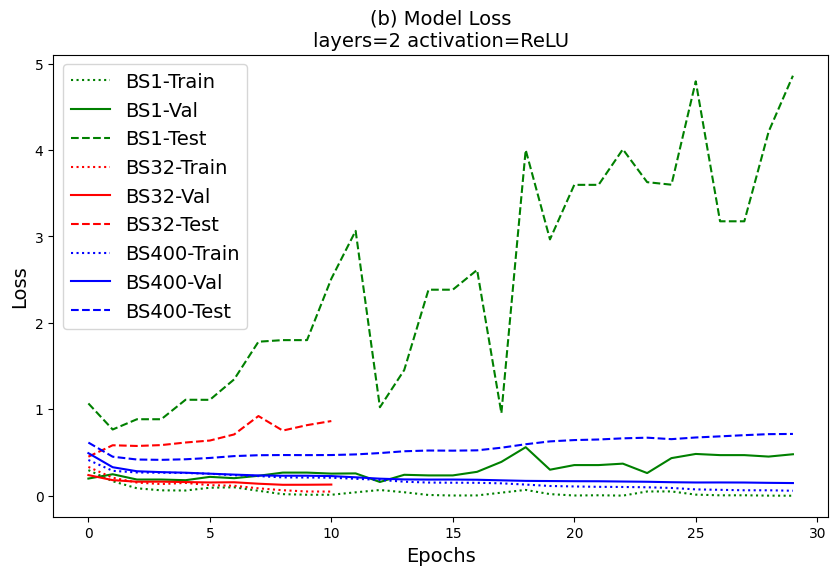

In [355]:
BS1_train_losses = []
BS1_train_accuracies = []
BS1_val_losses = []
BS1_val_accuracies = []
BS1_test_losses = []
BS1_test_accuracies = []

BS32_train_losses = []
BS32_train_accuracies = []
BS32_val_losses = []
BS32_val_accuracies = []
BS32_test_losses = []
BS32_test_accuracies = []

BS400_train_losses = []
BS400_train_accuracies = []
BS400_val_losses = []
BS400_val_accuracies = []
BS400_test_losses = []
BS400_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 3
epsilon = 0.0001


layers = 2
activation = 'ReLU'

width = 64
dropout = 0.0

# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# batch_size = 1
batch_size = 1

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
#     nn.BatchNorm1d(256*256*1),
    nn.LayerNorm(256*256*1),
    
    nn.Linear(256*256*1, width), 
#     nn.BatchNorm1d(width),
    nn.LayerNorm(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False, batch_size=batch_size)
test_loader = test_data_loader(two_d_output=False, batch_size=batch_size)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BS1_train_losses.append(train_losses)
    BS1_train_accuracies.append(train_accuracies)
    BS1_val_losses.append(val_losses)
    BS1_val_accuracies.append(val_accuracies)
    BS1_test_losses.append(test_losses)
    BS1_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# batch_size = 32
batch_size = 32

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False, batch_size=batch_size)
test_loader = test_data_loader(two_d_output=False, batch_size=batch_size)


for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BS32_train_losses.append(train_losses)
    BS32_train_accuracies.append(train_accuracies)
    BS32_val_losses.append(val_losses)
    BS32_val_accuracies.append(val_accuracies)
    BS32_test_losses.append(test_losses)
    BS32_test_accuracies.append(test_accuracies)


# ======================================================================================================
# batch_size = 400
batch_size = 400

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False, batch_size=batch_size)
test_loader = test_data_loader(two_d_output=False, batch_size=batch_size)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BS400_train_losses.append(train_losses)
    BS400_train_accuracies.append(train_accuracies)
    BS400_val_losses.append(val_losses)
    BS400_val_accuracies.append(val_accuracies)
    BS400_test_losses.append(test_losses)
    BS400_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(BS1_train_accuracies[i], color='g', linestyle=':')
    ax.plot(BS1_val_accuracies[i], color='g')
    ax.plot(BS1_test_accuracies[i], color='g', linestyle='--')

    ax.plot(BS32_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(BS32_val_accuracies[i], color='r')
    ax.plot(BS32_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(BS400_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(BS400_val_accuracies[i], color='b')
    ax.plot(BS400_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BS1-Train', 'BS1-Val', 'BS1-Test', 'BS32-Train', 'BS32-Val', 'BS32-Test', 'BS400-Train', 'BS400-Val', 'BS400-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_batch_size_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_BS_1_32_400.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(BS1_train_losses[i], color='g', linestyle=':')
    ax.plot(BS1_val_losses[i], color='g')
    ax.plot(BS1_test_losses[i], color='g', linestyle='--')

    ax.plot(BS32_train_losses[i], color='r', linestyle=':')    
    ax.plot(BS32_val_losses[i], color='r')
    ax.plot(BS32_test_losses[i], color='r', linestyle='--')
    
    ax.plot(BS400_train_losses[i], color='b', linestyle=':')    
    ax.plot(BS400_val_losses[i], color='b')
    ax.plot(BS400_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BS1-Train', 'BS1-Val', 'BS1-Test', 'BS32-Train', 'BS32-Val', 'BS32-Test', 'BS400-Train', 'BS400-Val', 'BS400-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_batch_size_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_BS_1_32_400.png')

plt.show()

In [ ]:
### batch size 1, 32, 512

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LayerNorm((65536,), eps=1e-05, elementwise_affine=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)
Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Epoch 1/30, Train Loss: 0.2956, Train Accu.: 88.12% Val Loss: 0.2841, Val Accu.: 89.25% Test Loss: 0.9148, Test Accu.: 66.75%
Epoch 2/30, Train Loss: 0.1846, Train Accu.: 92.88% Val Loss: 0.1823, Val Accu.: 93.75% Test Loss: 0.7321, Test Accu.: 72.50%
Epoch 3/30, Train Loss: 0.1018, Train Accu.: 96.31% Val Loss: 0.1924, Val Accu.: 94.25% Test Loss: 1.3414, 

Epoch 26/30, Train Loss: 0.0289, Train Accu.: 99.06% Val Loss: 0.1589, Val Accu.: 94.75% Test Loss: 1.2013, Test Accu.: 76.25%
Epoch 27/30, Train Loss: 0.0131, Train Accu.: 99.69% Val Loss: 0.1536, Val Accu.: 94.50% Test Loss: 1.2016, Test Accu.: 76.25%
Epoch 28/30, Train Loss: 0.0153, Train Accu.: 99.44% Val Loss: 0.1462, Val Accu.: 95.25% Test Loss: 1.3348, Test Accu.: 75.75%
Epoch 29/30, Train Loss: 0.0088, Train Accu.: 99.75% Val Loss: 0.1623, Val Accu.: 95.00% Test Loss: 1.2123, Test Accu.: 77.00%
Epoch 30/30, Train Loss: 0.0183, Train Accu.: 99.56% Val Loss: 0.1647, Val Accu.: 95.00% Test Loss: 1.3364, Test Accu.: 75.75%
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=65536, out_features=64, bias=True)
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_feature

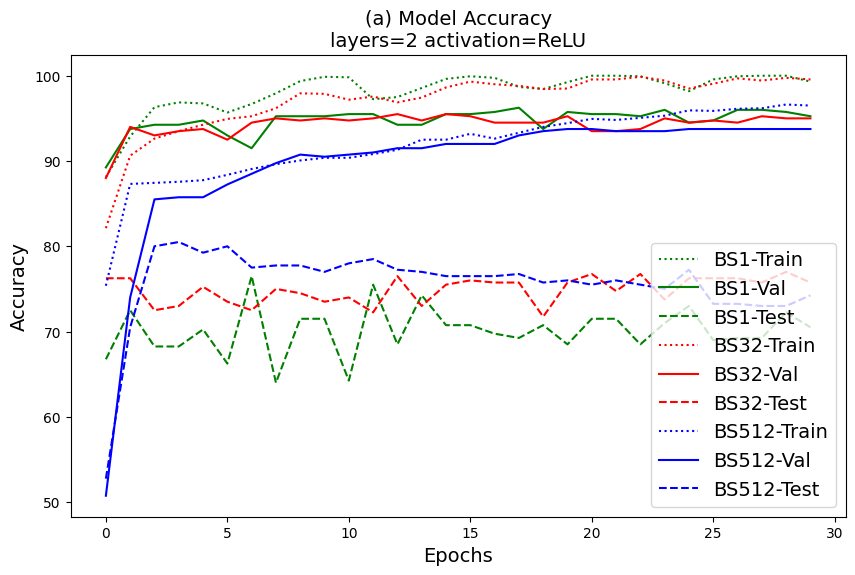

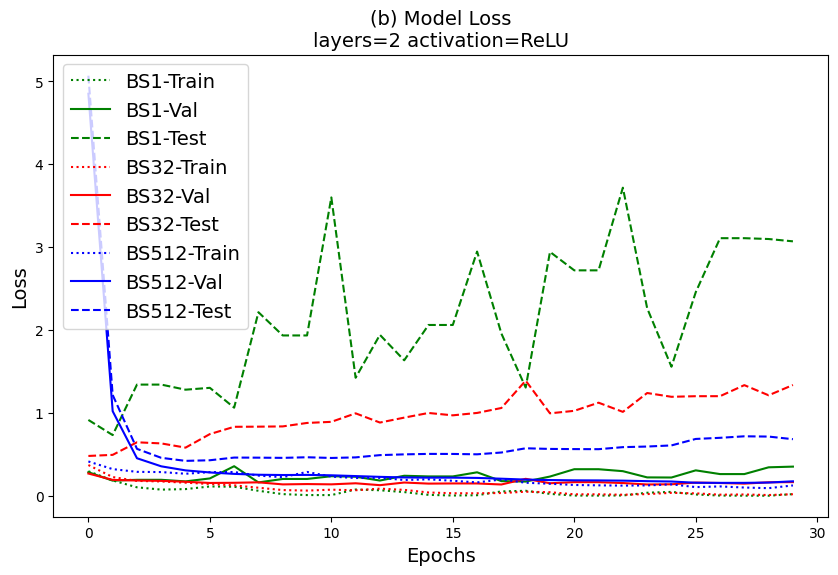

In [356]:
BS1_train_losses = []
BS1_train_accuracies = []
BS1_val_losses = []
BS1_val_accuracies = []
BS1_test_losses = []
BS1_test_accuracies = []

BS32_train_losses = []
BS32_train_accuracies = []
BS32_val_losses = []
BS32_val_accuracies = []
BS32_test_losses = []
BS32_test_accuracies = []

BS512_train_losses = []
BS512_train_accuracies = []
BS512_val_losses = []
BS512_val_accuracies = []
BS512_test_losses = []
BS512_test_accuracies = []


trials = 1
epochs = 30
# hyperparameters for early stop
patience = 3
epsilon = 0.0001


layers = 2
activation = 'ReLU'

width = 64
dropout = 0.0

# checkpoint_filename = f'model_classification_L{layers}_W{width}_{activation}.pth'

# ======================================================================================================
# batch_size = 1
batch_size = 1

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
#     nn.BatchNorm1d(256*256*1),
    nn.LayerNorm(256*256*1),
    
    nn.Linear(256*256*1, width), 
#     nn.BatchNorm1d(width),
    nn.LayerNorm(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False, batch_size=batch_size)
test_loader = test_data_loader(two_d_output=False, batch_size=batch_size)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BS1_train_losses.append(train_losses)
    BS1_train_accuracies.append(train_accuracies)
    BS1_val_losses.append(val_losses)
    BS1_val_accuracies.append(val_accuracies)
    BS1_test_losses.append(test_losses)
    BS1_test_accuracies.append(test_accuracies)

    
# ======================================================================================================
# batch_size = 32
batch_size = 32

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False, batch_size=batch_size)
test_loader = test_data_loader(two_d_output=False, batch_size=batch_size)


for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BS32_train_losses.append(train_losses)
    BS32_train_accuracies.append(train_accuracies)
    BS32_val_losses.append(val_losses)
    BS32_val_accuracies.append(val_accuracies)
    BS32_test_losses.append(test_losses)
    BS32_test_accuracies.append(test_accuracies)


# ======================================================================================================
# batch_size = 512
batch_size = 512

model = nn.Sequential(
    nn.Flatten(),
    
    # normalization 
    nn.BatchNorm1d(256*256*1),
    
    nn.Linear(256*256*1, width), 
    nn.BatchNorm1d(width),
    nn.ReLU(), 
    nn.Dropout(dropout), 
    
    nn.Linear(width, 1)

).cuda()

print(model)

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader = data_loader(two_d_output=False, batch_size=batch_size)
test_loader = test_data_loader(two_d_output=False, batch_size=batch_size)

for i in range(trials):
    model_trained, train_losses, train_accuracies, \
    val_losses, val_accuracies, \
    test_losses, test_accuracies = training(model, train_loader, val_loader, test_loader, 
                                            epochs, patience, epsilon, criterion, optimizer, lr_scheduler, 
                                            loss_mode='BCE')
    
    BS512_train_losses.append(train_losses)
    BS512_train_accuracies.append(train_accuracies)
    BS512_val_losses.append(val_losses)
    BS512_val_accuracies.append(val_accuracies)
    BS512_test_losses.append(test_losses)
    BS512_test_accuracies.append(test_accuracies)    
    


# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(BS1_train_accuracies[i], color='g', linestyle=':')
    ax.plot(BS1_val_accuracies[i], color='g')
    ax.plot(BS1_test_accuracies[i], color='g', linestyle='--')

    ax.plot(BS32_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(BS32_val_accuracies[i], color='r')
    ax.plot(BS32_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(BS512_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(BS512_val_accuracies[i], color='b')
    ax.plot(BS512_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BS1-Train', 'BS1-Val', 'BS1-Test', 'BS32-Train', 'BS32-Val', 'BS32-Test', 'BS512-Train', 'BS512-Val', 'BS512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_batch_size_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_BS_1_32_512_no_early_stop.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(BS1_train_losses[i], color='g', linestyle=':')
    ax.plot(BS1_val_losses[i], color='g')
    ax.plot(BS1_test_losses[i], color='g', linestyle='--')

    ax.plot(BS32_train_losses[i], color='r', linestyle=':')    
    ax.plot(BS32_val_losses[i], color='r')
    ax.plot(BS32_test_losses[i], color='r', linestyle='--')
    
    ax.plot(BS512_train_losses[i], color='b', linestyle=':')    
    ax.plot(BS512_val_losses[i], color='b')
    ax.plot(BS512_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BS1-Train', 'BS1-Val', 'BS1-Test', 'BS32-Train', 'BS32-Val', 'BS32-Test', 'BS512-Train', 'BS512-Val', 'BS512-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_batch_size_a_losses_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_BS_1_32_512_no_early_stop.png')

plt.show()

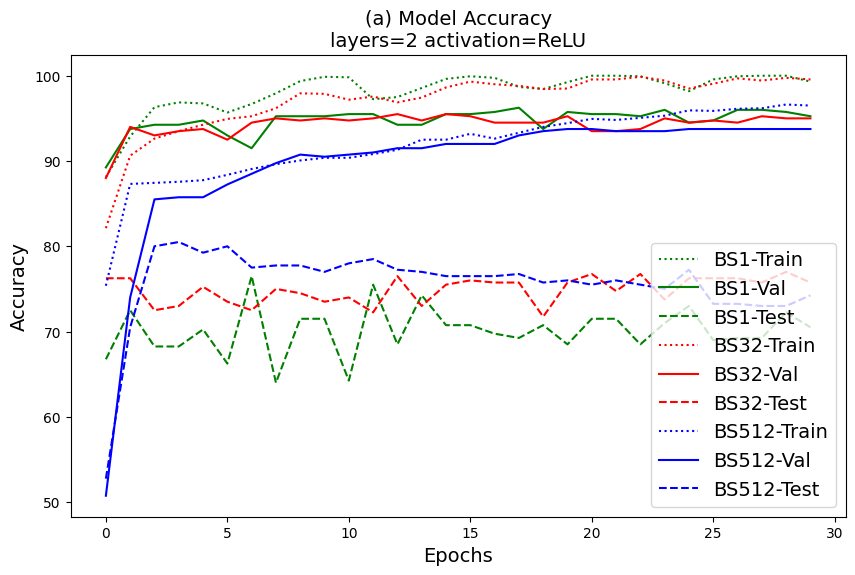

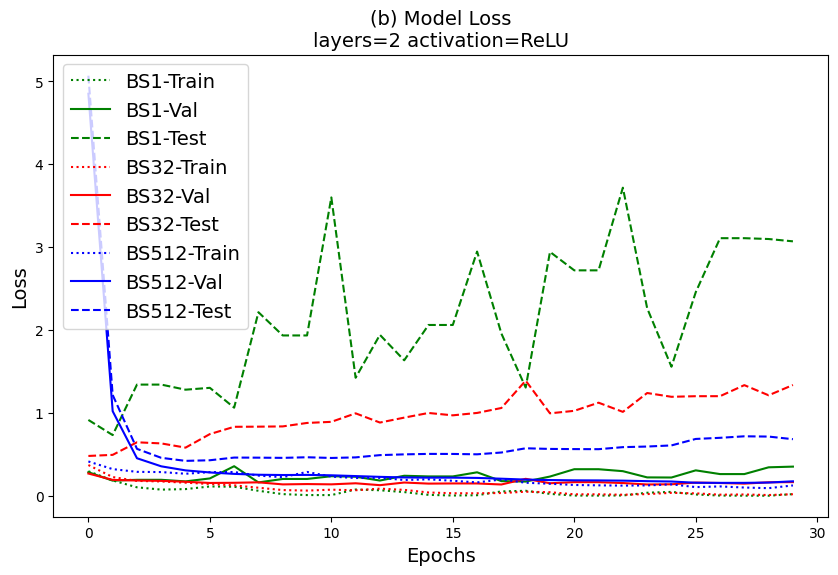

In [357]:
# ======================================================================================================
# Plotting training and validation accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(BS1_train_accuracies[i], color='g', linestyle=':')
    ax.plot(BS1_val_accuracies[i], color='g')
    ax.plot(BS1_test_accuracies[i], color='g', linestyle='--')

    ax.plot(BS32_train_accuracies[i], color='r', linestyle=':')    
    ax.plot(BS32_val_accuracies[i], color='r')
    ax.plot(BS32_test_accuracies[i], color='r', linestyle='--')
    
    ax.plot(BS512_train_accuracies[i], color='b', linestyle=':')    
    ax.plot(BS512_val_accuracies[i], color='b')
    ax.plot(BS512_test_accuracies[i], color='b', linestyle='--')
    
ax.set_title(f'(a) Model Accuracy\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['BS1-Train', 'BS1-Val', 'BS1-Test', 'BS32-Train', 'BS32-Val', 'BS32-Test', 'BS512-Train', 'BS512-Val', 'BS512-Test'], 
          fontsize=14)

plt.savefig(f'./assets/images/Compare_batch_size_a_accuracies_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_BS_1_32_512_no_early_stop.png')

plt.show()

# Plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(trials):
    ax.plot(BS1_train_losses[i], color='g', linestyle=':')
    ax.plot(BS1_val_losses[i], color='g')
    ax.plot(BS1_test_losses[i], color='g', linestyle='--')

    ax.plot(BS32_train_losses[i], color='r', linestyle=':')    
    ax.plot(BS32_val_losses[i], color='r')
    ax.plot(BS32_test_losses[i], color='r', linestyle='--')
    
    ax.plot(BS512_train_losses[i], color='b', linestyle=':')    
    ax.plot(BS512_val_losses[i], color='b')
    ax.plot(BS512_test_losses[i], color='b', linestyle='--')
    
ax.set_title(f'(b) Model Loss\nlayers={layers} activation={activation}', fontsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(['BS1-Train', 'BS1-Val', 'BS1-Test', 'BS32-Train', 'BS32-Val', 'BS32-Test', 'BS512-Train', 'BS512-Val', 'BS512-Test'], fontsize=14)

plt.savefig(f'./assets/images/Compare_batch_size_a_losses_L{layers}_W{width}_{activation}_T{trials}_E{epsilon}_BS_1_32_512_no_early_stop.png')

plt.show()